In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
from scipy.stats import ttest_1samp
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import warnings
import os
import json
from glob import glob
import re
warnings.filterwarnings("ignore")

In [2]:
def fisher_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def create_performance_df(category_performance_path, va_performance_path, category_labels, va_labels, regions='all'):
    if type(category_performance_path) == str:
        category_performance = pd.read_csv(category_performance_path)
    else:
        category_performance = category_performance_path
    if type(va_performance_path) == str:
        va_performance = pd.read_csv(va_performance_path)
    else:
        va_performance = va_performance_path
    performance_category = category_performance.melt(id_vars=['subject', 'region'],
                                                value_vars=category_labels,
                                                var_name='Emotion',
                                                value_name='Value')
    performance_va = va_performance.melt(id_vars=['subject', 'region'],
                                                value_vars=va_labels,
                                                var_name='Emotion',
                                                value_name='Value')
    performance_category['zvalue'] = fisher_z(performance_category['Value'])
    performance_va['zvalue'] = fisher_z(performance_va['Value'])
    performance_all = pd.concat([performance_category, performance_va])
    performance_all['emotion_type'] = ['category' if x in category_labels else 'valence_arousal' for x in performance_all['Emotion']]
    if regions != 'all':
        performance_all = performance_all[performance_all['region'].isin(regions)]
        performance_category = performance_category[performance_category['region'].isin(regions)]
        performance_va = performance_va[performance_va['region'].isin(regions)]
    return performance_all, performance_category, performance_va

def multiple_t_tests(performance_all, group_columns, value_column='zvalue'):
    #iterate over all combinations of groups in group_columns
    groups_combinations = performance_all[group_columns].drop_duplicates()
    t_values, p_values = [], []
    for idx, group in groups_combinations.iterrows():
        data = performance_all
        for column, value in group.items():
            data = data[data[column] == value]
        t_stat, p_two_tailed = ttest_1samp(data[value_column], 0)
        t_values.append(t_stat)
        p_one_tailed = p_two_tailed / 2 if data[value_column].mean() > 0 else 1.0 - p_two_tailed / 2
        p_values.append(p_one_tailed)
        
    stats_df = pd.DataFrame(groups_combinations)
    stats_df['t_value'] = t_values
    stats_df['p_value'] = p_values
    #correct the p_values for multiple comparisons using fdr
    stats_df['p_value_corrected'] = statsmodels.stats.multitest.multipletests(stats_df['p_value'], method='fdr_bh')[1]

    return stats_df

def bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000, ci=0.95):
    data = np.asarray(data)
    
    bootstrap_samples = np.random.choice(data, (n_bootstrap, len(data)), replace=True)
    bootstrap_statistics = np.apply_along_axis(statistic, 1, bootstrap_samples)
    
    lower_percentile = (1 - ci) / 2
    upper_percentile = 1 - lower_percentile
    
    ci_lower = np.percentile(bootstrap_statistics, lower_percentile * 100)
    ci_upper = np.percentile(bootstrap_statistics, upper_percentile * 100)
    
    return (ci_lower, ci_upper)

def bootstrap_analysis(df, group_name):
    results = []

    for group in df[group_name].unique():
        group_data = df[df[group_name] == group]
        
        # bootstrap CIs for Value and zvalue
        value_ci = bootstrap_ci(group_data['Value'])
        zvalue_ci = bootstrap_ci(group_data['zvalue'])
        value_mean = group_data['Value'].mean()
        zvalue_mean = group_data['zvalue'].mean()
        
        results.append({
            group_name: group,
            'Value_Mean': value_mean,
            'Value_CI_Lower': value_ci[0],
            'Value_CI_Upper': value_ci[1],
            'zvalue_Mean': zvalue_mean,
            'zvalue_CI_Lower': zvalue_ci[0],
            'zvalue_CI_Upper': zvalue_ci[1]
        })
    
    return pd.DataFrame(results)

def plot_subjectConnected_performance_scatter(performance_all, title, legend_title, outer_x_order, outer_x_labels, 
                                              outer_x_column_name, inner_x_order, inner_x_labels, inner_x_column_name, 
                                              y_column_name, inner_x_colors, subject_column_name, outer_shift=1.5, 
                                              inner_shift=0.8, jitter=0.2, figsize=(12, 6), legend_loc='upper left', 
                                              legend_bbox_to_anchor=(1, 1), yrange=None, yaxis_label='Prediction-Outcome Correlation', 
                                              xlabel='', save=None, ax=None,diff_outer_colors=False, inner_x_filling_colors=None,
                                              dashed_zero_line=False):
    
    inner_x_shift = {group: idx * inner_shift * outer_shift for idx, group in enumerate(inner_x_order)}
    outer_x_shift = {group: idx * len(inner_x_order) * outer_shift for idx, group in enumerate(outer_x_order)}
    
    performance_all['outer_shifted'] = performance_all.apply(
        lambda row: outer_x_shift[row[outer_x_column_name]] + 
                    inner_x_shift[row[inner_x_column_name]] + 
                    np.random.uniform(-jitter, jitter), axis=1
    )

    sns.set(style="white")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if diff_outer_colors:
        performance_all['inner_outer_comnination'] = [f'{inner}_{outer}' for inner, outer in zip(performance_all[inner_x_column_name], performance_all[outer_x_column_name])]
        scatter = sns.scatterplot(data=performance_all, x='outer_shifted', y=y_column_name, hue='inner_outer_comnination',
                              s=100, alpha=0.5, palette=inner_x_colors, ax=ax)
    else:
        if inner_x_filling_colors:
            scatter = sns.scatterplot(data=performance_all, x='outer_shifted', y=y_column_name, hue=inner_x_column_name, 
                              s=100, alpha=0.6, palette=inner_x_filling_colors, edgecolor=None, ax=ax)
            unique_hue_values = performance_all[inner_x_column_name].unique()
            fill_color_map = dict(zip(unique_hue_values, sns.color_palette(inner_x_filling_colors, len(unique_hue_values))))
            edge_color_map = dict(zip(unique_hue_values, sns.color_palette(inner_x_colors, len(unique_hue_values))))
            for i, point in enumerate(scatter.collections):
                hues = performance_all[inner_x_column_name].values  # Get hue values for all points
                face_colors = [fill_color_map[hue] for hue in hues]  # Assign face colors
                edge_colors = [edge_color_map[hue] for hue in hues]  # Assign edge colors
            
                point.set_facecolor(face_colors)
                point.set_edgecolor(edge_colors)
                point.set_linewidth(1) 
        else:
            scatter = sns.scatterplot(data=performance_all, x='outer_shifted', y=y_column_name, hue=inner_x_column_name, 
                              s=100, alpha=0.5, palette=inner_x_colors, ax=ax)


    # subject-wise connection lines
    subjects = performance_all[subject_column_name].unique()
    for subject in subjects:
        subject_data = performance_all[performance_all[subject_column_name] == subject]
        for outer_group in outer_x_order:
            inner_data = subject_data[subject_data[outer_x_column_name] == outer_group]
            inner_data = inner_data.sort_values('outer_shifted')
            if len(inner_data) > 1:
                ax.plot(inner_data['outer_shifted'], inner_data[y_column_name], 
                        color='gray', alpha=0.5, lw=1)
    
    # mean lines for each inner-outer combination
    mean_line_handles = []
    for outer_group in outer_x_order:
        for inner_group in inner_x_order:
            subset = performance_all[(performance_all[outer_x_column_name] == outer_group) & (performance_all[inner_x_column_name] == inner_group)]
            if not subset.empty:
                mean_y = subset[y_column_name].mean()
                mean_x = outer_x_shift[outer_group] + inner_x_shift[inner_group]
                ax.plot([mean_x - jitter, mean_x + jitter], [mean_y, mean_y], 
                        color='black', lw=2, label='_mean_line_')  # Avoid duplicate labels
                mean_line_handles.append(mlines.Line2D([], [], color='black', lw=2, label="Mean"))

    xticks, xticklabels = [], []
    for outer_idx, outer_group in enumerate(outer_x_order):
        if diff_outer_colors:
            for inner_idx, inner_group in enumerate(inner_x_order):
                xticks.append(outer_x_shift[outer_group] + inner_x_shift[inner_group])
                xticklabels.append(inner_x_labels[inner_idx+outer_idx*len(inner_x_order)])
        else:
            xticks.append(outer_x_shift[outer_group] + np.mean([inner_x_shift[i] for i in inner_x_order]))
            xticklabels.append(outer_x_labels[outer_idx])
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, weight='bold')
    ax.set_xlabel(xlabel, weight='bold')
    ax.set_ylabel(yaxis_label, weight='bold')
    ax.set_title(title, weight='bold')

    if yrange:
        ax.set_ylim(yrange)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    if diff_outer_colors:
        legend_handles = [mlines.Line2D([], [], marker='o', color=color, linestyle='None', markersize=10, label=label, alpha=0.5) 
                      for label, color in zip(outer_x_labels, [inner_x_colors[i] for i in [2+len(inner_x_order)*j for j in range(len(outer_x_order))]])]
    if inner_x_filling_colors:
        legend_handles = [mlines.Line2D([], [], marker='o', linestyle='None', markersize=10, markerfacecolor=fill_color, markeredgecolor=edge_color, markeredgewidth=1.5, alpha=0.6, label=label) 
                          for label, fill_color, edge_color in zip(inner_x_labels, inner_x_filling_colors, inner_x_colors)]
    else:
        legend_handles = [mlines.Line2D([], [], marker='o', color=color, linestyle='None', markersize=10, label=label, alpha=0.5) 
                        for label, color in zip(inner_x_labels, inner_x_colors)]
    legend_handles.append(mlines.Line2D([], [], color='black', lw=2, label="Mean"))  # Mean line
    ax.legend(handles=legend_handles, title=legend_title, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor)

    if dashed_zero_line:  
        if ax.get_ylim()[0] > 0:
            ax.set_ylim(bottom=-0.01)
        ax.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=0)

    plt.tight_layout()

    if save:
        plt.savefig(save, dpi=600)

    if ax is None:
        plt.show()

def plot_performance_scatter(performance_all, title, legend_title, group_order, group_labels, group_column_name, ori_region_labels, region_labels):
    region_shift = {region: idx * 0.8 for idx, region in enumerate(ori_region_labels)}
    emotion_shift = {emotion: idx * len(ori_region_labels) * 1.5 for idx, emotion in enumerate(group_order)}
    performance_all['region_shifted'] = performance_all.apply(
        lambda row: emotion_shift[row[group_column_name]] + region_shift[row['region']], axis=1
    )
    sns.set(style="white")
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=performance_all, x='region_shifted', y='Value', hue='region', style='region', s=100, legend=True, alpha=0.5, palette='tab20')
    subjects = performance_all['subject'].unique()
    for subject in subjects:
        subject_data = performance_all[performance_all['subject'] == subject]
        for emotion in group_order:
            emotion_data = subject_data[subject_data[group_column_name] == emotion]
            emotion_data = emotion_data.sort_values('region_shifted')
            if len(emotion_data) > 1:
                plt.plot(emotion_data['region_shifted'], emotion_data['Value'], color='gray', alpha=0.5, lw=1)
    plt.xlabel('')
    plt.ylabel('Prediction-Outcome Correlation')
    plt.title(title)
    xticks = []
    xticklabels = []
    for emo_idx, emotion in enumerate(group_order):
        xticks.append(emotion_shift[emotion])  
        xticklabels.append(group_labels[emo_idx])
        for region in ori_region_labels[1:]:
            xticks.append(emotion_shift[emotion] + region_shift[region])  
            xticklabels.append('')
    plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)
    handles, labels = plt.gca().get_legend_handles_labels()
    if region_labels != ori_region_labels:
        new_labels = []
        for label in ori_region_labels:
            new_labels.append(region_labels[labels.index(label)])
        labels = new_labels
    else:
        labels = region_labels
    plt.legend(handles, labels, title=legend_title, loc='upper right')

    #remove top and right axes 
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def get_region_diff_df(performance_all, region_name1, region_name2):
    region_values = performance_all.pivot_table(index=['subject', 'Emotion', 'emotion_type'], columns='region', values='Value').reset_index()
    region_values['Difference'] = region_values[region_name1] - region_values[region_name2]
    region_zvalues = performance_all.pivot_table(index=['subject', 'Emotion', 'emotion_type'], columns='region', values='zvalue').reset_index()
    region_values['zDifference'] = region_zvalues[region_name1] - region_zvalues[region_name2]
    return region_values

def plot_performance_diff_across_regions(performance_all, title, region_name1, region_name2, region_name1_label, region_name2_label, emotion_order, emotion_labels, save=None):
    sns.set(style="white")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    region_values = get_region_diff_df(performance_all, region_name1, region_name2)
    plt.figure(figsize=(16, 6))
    #plot half violin
    sns.violinplot(data=region_values, x='Emotion', y='Difference', order=emotion_order, color='lightgray')
    #change x tick labels to emotion labels
    plt.xticks(ticks=[i for i in range(len(emotion_order))], labels=emotion_labels)
    for violin in plt.gca().collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=plt.gca().transData))
    #plot scatter
    sns.scatterplot(data=region_values, x='Emotion', y='Difference', s=100, color='gray', alpha=0.5)
    #move the scatter dots to the right to aviod overlap with violin plot
    for dots in plt.gca().collections[1:]:
        dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))
    #add zero line    
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.xlabel('')
    y_label = f'Difference in Prediction-Outcome Correlation\n({region_name1_label} - {region_name2_label})'
    plt.ylabel(y_label, weight='bold')
    plt.xticks(rotation=45, weight='bold')
    plt.title(title)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=600)
    plt.show()

def get_region_diff_df_brainToTEM(performance_all, TEM_part_to_use, region_pair1, region_pair2=None):
    region_values = performance_all.pivot_table(index=['fmri_subject', TEM_part_to_use,'TEMcell'], columns='brain_region', values='Value').reset_index()
    region_values[f'Difference_{region_pair1[0]}_{region_pair1[1]}'] = region_values[region_pair1[0]] - region_values[region_pair1[1]]
    if region_pair2:
        region_values[f'Difference_{region_pair2[0]}_{region_pair2[1]}'] = region_values[region_pair2[0]] - region_values[region_pair2[1]]
        #pivot to only have one column for difference and one column for zDifference and add a column for pair
        region_values = region_values.melt(id_vars=['fmri_subject', TEM_part_to_use,'TEMcell'], value_vars=[f'Difference_{region_pair1[0]}_{region_pair1[1]}', f'Difference_{region_pair2[0]}_{region_pair2[1]}'], var_name='Region_pair_column', value_name='Value')
    else:
        region_values = region_values.melt(id_vars=['fmri_subject', TEM_part_to_use,'TEMcell'], value_vars=[f'Difference_{region_pair1[0]}_{region_pair1[1]}'], var_name='Region_pair_column', value_name='Value')
    region_values['region_pair'] = [x.split('_')[1]+ '_' + x.split('_')[2] for x in region_values['Region_pair_column']]
    region_values.drop(columns='Region_pair_column', axis=1, inplace=True)
    return region_values

def plot_performance_violin_scatter(performance_all, x_name, group_name, colors, violin_border_colors, ori_x_labels, x_labels, legend_title, ori_legend_labels, legend_labels, title, y_label='Prediction-Outcome Correlation',add_y0=False):
    sns.set_style('white')
    #plot half violin
    ax = sns.violinplot(x=x_name, y='Value', hue=group_name, data=performance_all, palette=colors, scale="width", alpha = 0.8, dodge=True, order = ori_x_labels)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for idx, violin in enumerate(ax.collections):
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))
        #violin.set_edgecolor(violin_border_colors[idx])
        violin.set_edgecolor(violin_border_colors[idx % len(violin_border_colors)])
        violin.set_linewidth(2)
    #plot scatter   
    old_len_collections = len(ax.collections)
    sns.stripplot(x=x_name, y='Value', hue=group_name, data=performance_all, jitter=True, dodge=True, alpha=0.3, size=4, palette=colors, legend=False, ax=ax, order = ori_x_labels)
    #move the scatter dots to the right to aviod overlap with violin plot
    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))  

    plt.ylabel(y_label)
    plt.xlabel('')
    plt.xticks(ticks=[i for i in range(len(x_labels))], labels=x_labels)
    handles, labels = ax.get_legend_handles_labels()
    #ori_legend_labels order is matched with legend_labels, so if label order in labels is different from the original legend labels, reorder the labels
    if labels != ori_legend_labels:
        new_labels = []
        for label in ori_legend_labels:
            new_labels.append(legend_labels[labels.index(label)])
        labels = new_labels
    else:
        labels = legend_labels
    ax.legend(handles, labels, title=legend_title, loc='upper left')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if add_y0:
       #add zero line and make sure it's not covered by the scatter dots
        plt.axhline(0, color='black', linewidth=1, linestyle='--', zorder=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Anterior, posterior hippocampus predicting category vs. binary valence-arousal

In [86]:
category_labels = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard', 'Satisfaction', 'WarmHeartedness', 'Happiness', 'Pride', 'Love']
va_labels = ['Good', 'Bad', 'Calm', 'AtEase']
category_path_apHC = './outputs/rep3/ratings_prediction_performance/brain/category/categoryRatings_prediction_performance_generalized_across_movies_apHC.csv'
va_path_apHC = './outputs/rep3/ratings_prediction_performance/brain/binary_valence_arousal/binaryValenceArousalRatings_prediction_performance_generalized_across_movies_apHC.csv'
performance_all_apHC, _, _ = create_performance_df(category_path_apHC, va_path_apHC, category_labels, va_labels)
performance_all_apHC["region"] = pd.Categorical(
    performance_all_apHC["region"], 
    categories=['anteriorHippocampus', 'posteriorHippocampus'],  # Specify the desired order to make anterior HC the reference in lme model
    ordered=True
)
performance_all_apHC['emotion_type'] = pd.Categorical(performance_all_apHC['emotion_type'], categories=['valence_arousal','category'], ordered=True)

In [97]:
print(multiple_t_tests(performance_all_apHC, ['region', 'Emotion']))

                   region          Emotion       p_value  p_value_corrected
0     anteriorHippocampus            Anger  2.122700e-04       2.886873e-04
1    posteriorHippocampus            Anger  1.252316e-05       2.365486e-05
48    anteriorHippocampus          Anxiety  9.419950e-09       4.003479e-08
49   posteriorHippocampus          Anxiety  1.092467e-11       7.428772e-11
96    anteriorHippocampus             Fear  1.895724e-08       7.161625e-08
97   posteriorHippocampus             Fear  6.783559e-10       3.294871e-09
144   anteriorHippocampus         Surprise  2.015918e-14       3.427061e-13
145  posteriorHippocampus         Surprise  6.483438e-16       2.204369e-14
192   anteriorHippocampus            Guilt  3.075437e-06       6.535304e-06
193  posteriorHippocampus            Guilt  1.109592e-07       3.772611e-07
240   anteriorHippocampus          Disgust  1.846497e-10       1.046348e-09
241  posteriorHippocampus          Disgust  1.542987e-12       1.311539e-11
288   anteri

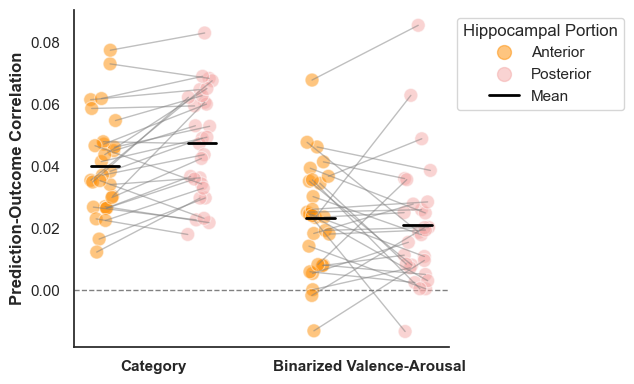

In [100]:
performance_all_apHC_mean = performance_all_apHC.groupby(['subject','region', 'emotion_type'], as_index=False).aggregate({'zvalue': 'mean', 'Value': 'mean'})
plot_subjectConnected_performance_scatter(performance_all_apHC_mean, 
                                          legend_title='Hippocampal Portion', title='',
                                          outer_x_order=['category', 'valence_arousal'], outer_x_labels=['Category', 'Binarized Valence-Arousal'], outer_x_column_name='emotion_type',
                                          inner_x_order=['anteriorHippocampus', 'posteriorHippocampus'], inner_x_labels=['Anterior', 'Posterior'], inner_x_column_name='region',
                                          y_column_name='Value',
                                          inner_x_colors=['#FE8D01','#F4A9A7'],#['#70c17f','#7ca9cc'], 
                                          subject_column_name='subject',
                                          outer_shift=1.5, inner_shift=0.9, jitter=0.2, figsize=(6.5, 4),
                                            legend_loc='upper left', legend_bbox_to_anchor=(1, 1),
                                              dashed_zero_line=True,
                                            save='./outputs/performance_CateBiVA_apHC.jpeg')

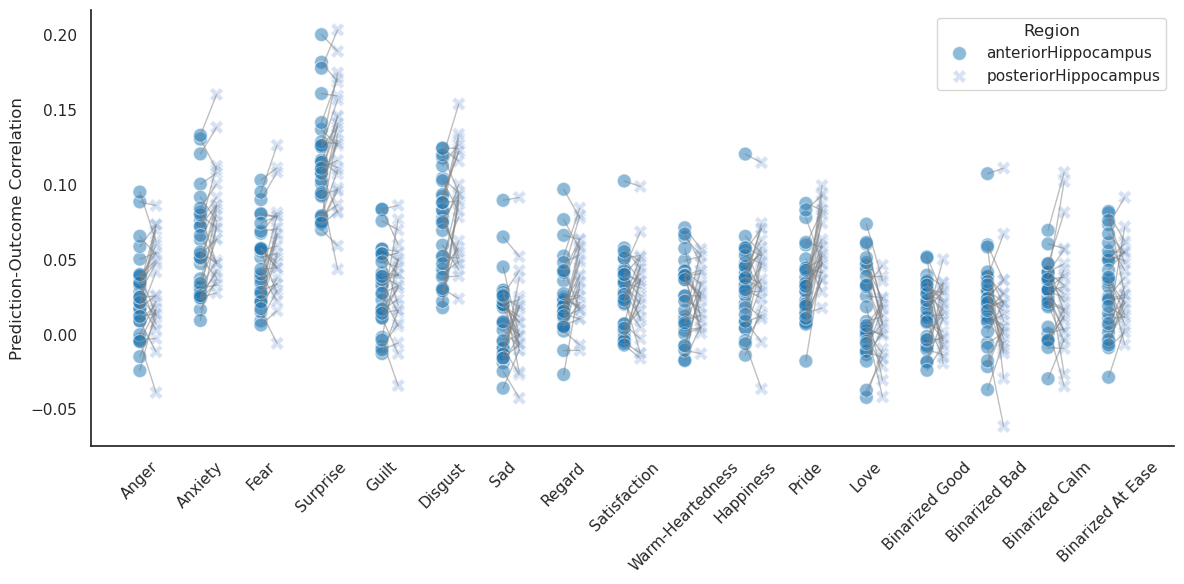

In [12]:
emotion_order = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard', 'Satisfaction', 'WarmHeartedness', 'Happiness', 'Pride', 'Love', 'Good', 'Bad', 'Calm', 'AtEase']
emotion_labels = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard', 'Satisfaction', 'Warm-Heartedness', 'Happiness', 'Pride', 'Love', 'Binarized Good', 'Binarized Bad', 'Binarized Calm', 'Binarized At Ease']
plot_performance_scatter(performance_all_apHC, '', 'Region', emotion_order, emotion_labels, ['anteriorHippocampus', 'posteriorHippocampus'])

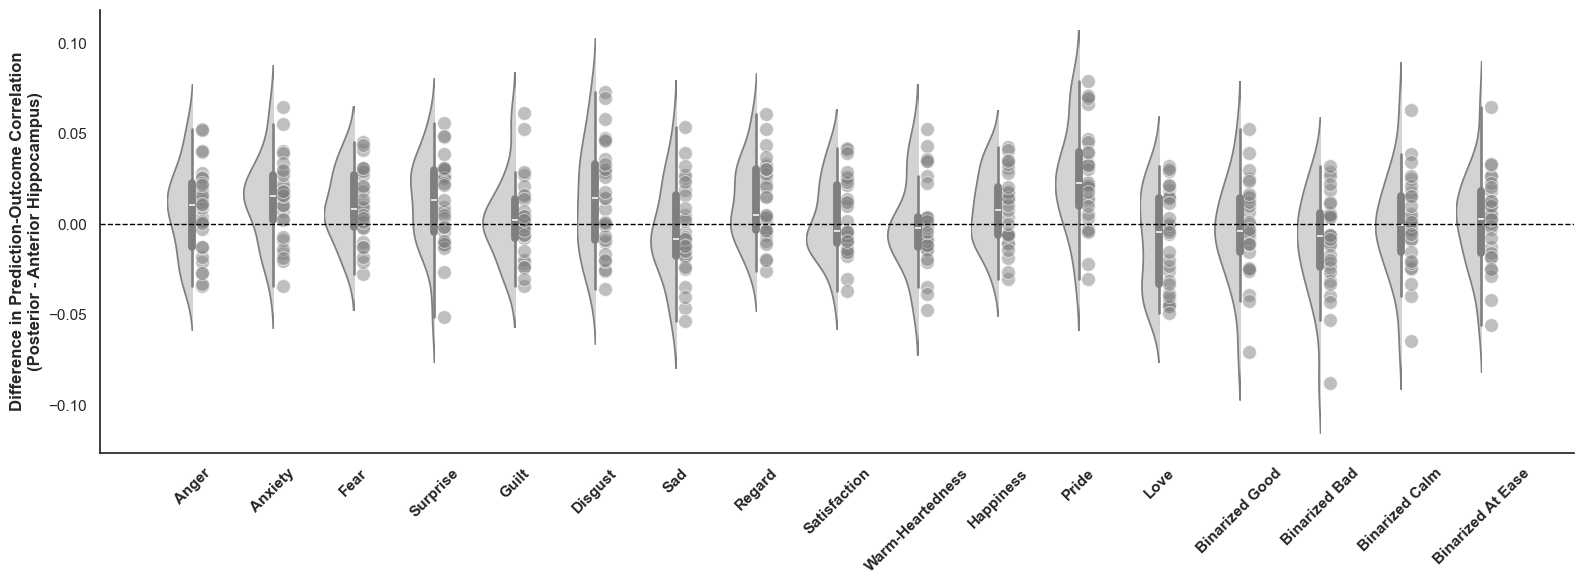

In [9]:
emotion_order = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard', 'Satisfaction', 'WarmHeartedness', 'Happiness', 'Pride', 'Love', 'Good', 'Bad', 'Calm','AtEase']
emotion_labels = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard', 'Satisfaction', 'Warm-Heartedness', 'Happiness', 'Pride', 'Love', 'Binarized Good', 'Binarized Bad', 'Binarized Calm', 'Binarized At Ease']
plot_performance_diff_across_regions(performance_all_apHC, '', 'posteriorHippocampus', 'anteriorHippocampus', 'Posterior', 'Anterior Hippocampus',
                                     emotion_order, emotion_labels,
                                    save='./outputs/performance_CateBiVA_apHCdiff_allemos.jpeg')

In [9]:
post_ant_HC_diff = get_region_diff_df(performance_all_apHC, 'posteriorHippocampus', 'anteriorHippocampus')
print(multiple_t_tests(post_ant_HC_diff, ['Emotion'], 'zDifference'))

region          Emotion   t_value   p_value  p_value_corrected
0                 Anger  1.716489  0.048559           0.103188
1               Anxiety  3.215625  0.001637           0.013841
2                AtEase  0.404666  0.344399           0.532253
3                   Bad -1.863613  0.963553           0.963553
4                  Calm  0.017101  0.493239           0.645004
5               Disgust  2.590356  0.007525           0.021322
6                  Fear  2.794898  0.004634           0.016272
7                  Good -0.540963  0.703594           0.843325
8                 Guilt  0.596591  0.277787           0.472238
9             Happiness  2.031353  0.025904           0.062911
10                 Love -1.760621  0.955389           0.963553
11                Pride  5.148812  0.000009           0.000157
12               Regard  3.056279  0.002442           0.013841
13                  Sad -0.664543  0.744111           0.843325
14         Satisfaction  0.800918  0.214962           0

### HC, ERC, vmPFC predicting category vs. valence-arousal

In [19]:
category_labels = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard', 'Satisfaction', 'WarmHeartedness', 'Happiness', 'Pride', 'Love']
va_labels = ['Good', 'Bad', 'Calm', 'AtEase']
brain_regions_to_use = ['Hippocampus', 'EntorhinalCortex', 'vmPFC_a24_included']
category_path_HCECvmPF = './outputs/rep3/ratings_prediction_performance/brain/category/categoryRatings_prediction_performance_generalized_across_movies_hcecvmpfc.csv'
va_path_HCECvmPF = './outputs/rep3/ratings_prediction_performance/brain/valence_arousal/valenceArousalRatings_prediction_performance_generalized_across_movies_hcecvmpfc.csv'
performance_all_HCECvmPF, _, _ = create_performance_df(category_path_HCECvmPF, va_path_HCECvmPF, category_labels, va_labels, regions=brain_regions_to_use)

performance_all_HCECvmPF["region"] = pd.Categorical(
    performance_all_HCECvmPF["region"], 
    categories=brain_regions_to_use,  # Specify the desired order to make HC the reference in lme model
    ordered=True
)
performance_all_HCECvmPF["emotion_type"] = pd.Categorical(
    performance_all_HCECvmPF["emotion_type"], 
    categories=['category','valence_arousal'],  # Specify the desired order to make category the reference in lme model
    ordered=True
)
print(performance_all_HCECvmPF["region"].unique())

['Hippocampus', 'EntorhinalCortex', 'vmPFC_a24_included']
Categories (3, object): ['Hippocampus' < 'EntorhinalCortex' < 'vmPFC_a24_included']


#### Hippocampus

      emotion_type     Value    zvalue
0         category  0.052346  0.052528
1  valence_arousal  0.028585  0.028632
      emotion_type  Value_Mean  Value_CI_Lower  Value_CI_Upper  zvalue_Mean  \
0         category    0.052346        0.045790        0.058675     0.052528   
1  valence_arousal    0.028585        0.019385        0.038529     0.028632   

   zvalue_CI_Lower  zvalue_CI_Upper  
0         0.045384         0.059237  
1         0.019658         0.038874  


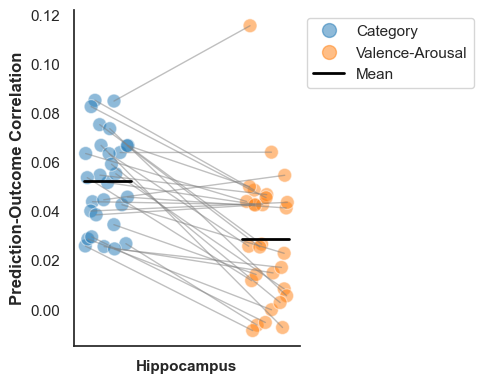

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
performance_all_HCECvmPF_mean = performance_all_HCECvmPF.groupby(['subject', 'region','emotion_type'], as_index=False).aggregate({'zvalue': 'mean', 'Value': 'mean'})
performance_all_HC_mean = performance_all_HCECvmPF_mean[performance_all_HCECvmPF_mean['region'] == 'Hippocampus']
performance_all_HC_mean["emotion_type"] = pd.Categorical(performance_all_HC_mean["emotion_type"], categories=['category','valence_arousal'], ordered=True)
plot_subjectConnected_performance_scatter(performance_all_HC_mean, 
                                          title='', legend_title='',
                                          outer_x_order=['Hippocampus'], outer_x_labels=['Hippocampus'], outer_x_column_name='region',
                                          inner_x_order=['category', 'valence_arousal'], inner_x_labels=['Category', 'Valence-Arousal'], inner_x_column_name='emotion_type',
                                          y_column_name='Value', inner_x_colors=['#1f77b4', '#ff7f0e'], subject_column_name='subject',
                                          outer_shift=1.5, inner_shift=0.9, jitter=0.2, figsize=(5, 4))#,
                                          #save='./outputs/performance_CateVA_HC.jpeg')


#print Value's and zvalue's subject mean for category and valence_arousal
print(performance_all_HC_mean.groupby(['emotion_type'], as_index=False).aggregate({'Value': 'mean', 'zvalue': 'mean'}))

bootstrap_results = bootstrap_analysis(performance_all_HC_mean,'emotion_type')
print(bootstrap_results)

#### Hippocampus vs. ERC/vmPFC 

In [6]:
#p_values_region_emotype = multiple_t_tests(performance_all_HCECvmPF, ['region', 'emotion_type'])
#(p_values_region_emotype)
p_values_region_emo = multiple_t_tests(performance_all_HCECvmPF, ['region', 'Emotion'])
p_values_region_emo.to_csv('./outputs/performance_CateVA_HCECvmPFC_allemos_ttest.csv', index=False)


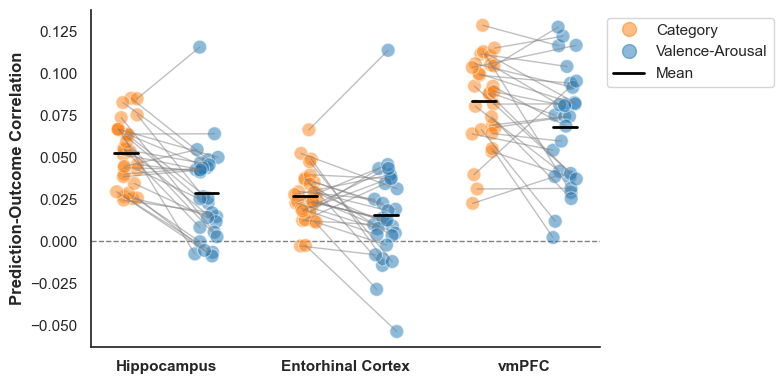

In [20]:
performance_all_HCECvmPF_mean = performance_all_HCECvmPF.groupby(['subject', 'region', 'emotion_type'], as_index=False).aggregate({'zvalue': 'mean', 'Value': 'mean'})
plot_subjectConnected_performance_scatter(performance_all_HCECvmPF_mean, 
                                          title='', legend_title='',
                                          outer_x_order=['Hippocampus', 'EntorhinalCortex', 'vmPFC_a24_included'], outer_x_labels=['Hippocampus', 'Entorhinal Cortex', 'vmPFC'], outer_x_column_name='region',
                                          inner_x_order=['category', 'valence_arousal'], inner_x_labels=['Category', 'Valence-Arousal'], inner_x_column_name='emotion_type',
                                          y_column_name='Value', inner_x_colors=['#ff7f0e','#1f77b4'], subject_column_name='subject',
                                          outer_shift=1.5, inner_shift=0.9, jitter=0.2, figsize=(8, 4),
                                          dashed_zero_line=True,
                                          save='./outputs/performance_CateVA_HCERCvmPFC_HCwarm.jpeg')

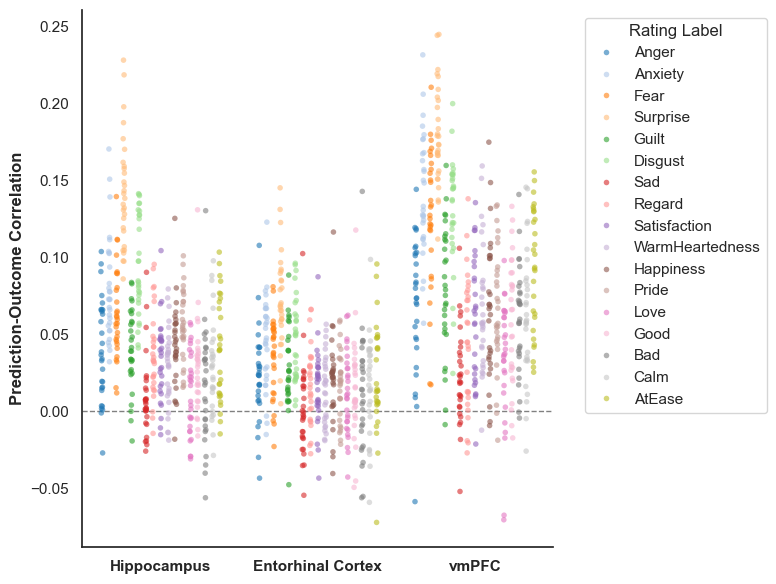

In [14]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Arial']
# plot scatter in another subplot
plt.figure(figsize=(8, 6))
#plt.subplot(2, 2, 1)
sns.stripplot(x='region', y='Value', hue='Emotion', data=performance_all_HCECvmPF, jitter=True, dodge=True, alpha=0.6, size=4, palette='tab20')
plt.ylabel('Prediction-Outcome Correlation', weight='bold')
plt.xlabel('')
plt.legend(title='Rating Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#set x ticks labels
plt.xticks(ticks=[0, 1, 2], labels=['Hippocampus', 'Entorhinal Cortex', 'vmPFC'], weight='bold')
#dashed zero line
plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=0)
plt.tight_layout()
plt.savefig('./outputs/performance_CateVA_HCECvmPFC_allemos.jpeg', dpi=600)
plt.show()

### Brain to TEM

In [98]:
num_walker_to_average = 10
TEM_walker_to_use = [f'randomWalker{i}' for i in range(num_walker_to_average)]
brain_to_tem_freq01 = pd.read_csv('./outputs/rep3/ratings_prediction_performance/brainToTEM/MDSseed121/iteration42000/walkRandomSeed42/brainToTEM_prediction_performance_generalized_across_movies_brainapHC_TEMpfreq01.csv')
brain_to_tem_freq234 = pd.read_csv('./outputs/rep3/ratings_prediction_performance/brainToTEM/MDSseed121/iteration42000/walkRandomSeed42/brainToTEM_prediction_performance_generalized_across_movies_brainapHC_TEMpfreq234.csv')
brain_to_tem_freq01 = brain_to_tem_freq01[brain_to_tem_freq01['TEM_walker'].isin(TEM_walker_to_use)]
brain_to_tem_freq234 = brain_to_tem_freq234[brain_to_tem_freq234['TEM_walker'].isin(TEM_walker_to_use)]

performance_freq01 = brain_to_tem_freq01.melt(id_vars=brain_to_tem_freq01.columns[-5:],
                                                value_vars=brain_to_tem_freq01.columns[:-5],
                                                var_name='TEMcell',
                                                value_name='Value')
performance_freq234 = brain_to_tem_freq234.melt(id_vars=brain_to_tem_freq234.columns[-5:],
                                            value_vars=brain_to_tem_freq234.columns[:-5],
                                            var_name='TEMcell',
                                            value_name='Value')
performance_freq01['zvalue'] = fisher_z(performance_freq01['Value'])
performance_freq234['zvalue'] = fisher_z(performance_freq234['Value'])
performance_all = pd.concat([performance_freq01, performance_freq234])

performance_all['Value'] = performance_all['Value'].fillna(performance_all['Value'].mean())
performance_all['zvalue'] = performance_all['zvalue'].fillna(performance_all['zvalue'].mean())
performance_all_averaged_apHCtopfreq01freq234 = (performance_all.groupby(['brain_region', 'fmri_subject', 'TEM_component', 'TEM_freq', 'TEMcell'], as_index=False).agg({'Value': 'mean', 'zvalue': 'mean'}))

performance_all_averaged_apHCtopfreq01freq234['cell_freq'] = [x[0:5] for x in performance_all_averaged_apHCtopfreq01freq234['TEMcell']]
performance_all_averaged_apHCtopfreq01freq234['brain_region'] = pd.Categorical(performance_all_averaged_apHCtopfreq01freq234['brain_region'], categories=['anteriorHippocampus', 'posteriorHippocampus'], ordered=True)
performance_all_averaged_apHCtopfreq01freq234['TEM_frequency'] = pd.Categorical(performance_all_averaged_apHCtopfreq01freq234['TEM_freq'], categories=['freq01', 'freq234'], ordered=True)

In [ ]:
model = mixedlm("zvalue ~ brain_region*TEM_freq", performance_all_averaged_apHCtopfreq01freq234 , 
                groups=performance_all_averaged_apHCtopfreq01freq234 ["fmri_subject"], re_formula="~cell_freq")
result = model.fit()
print(result.summary())

In [24]:
print(multiple_t_tests(performance_all_averaged_apHCtopfreq01freq234, ['brain_region', 'TEM_freq']))

               brain_region TEM_freq  p_value  p_value_corrected
0       anteriorHippocampus   freq01      0.0                0.0
200     anteriorHippocampus  freq234      0.0                0.0
11600  posteriorHippocampus   freq01      0.0                0.0
11800  posteriorHippocampus  freq234      0.0                0.0


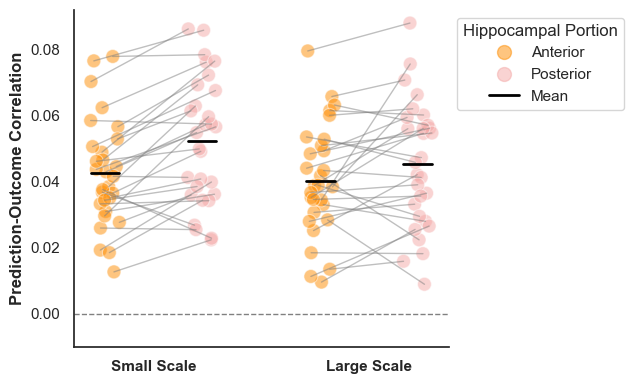

In [99]:
performance_all_averaged_apHCtopfreq01freq234_mean = performance_all_averaged_apHCtopfreq01freq234.groupby(['fmri_subject', 'brain_region', 'TEM_freq','TEM_component'], as_index=False).agg({'zvalue': 'mean', 'Value': 'mean'})
plot_subjectConnected_performance_scatter(performance_all_averaged_apHCtopfreq01freq234_mean,
                                            title='', legend_title='Hippocampal Portion',
                                            outer_x_order=['freq01', 'freq234'], outer_x_labels=['Small Scale', 'Large Scale'], outer_x_column_name='TEM_freq',
                                            inner_x_order=['anteriorHippocampus', 'posteriorHippocampus'], inner_x_labels=['Anterior', 'Posterior'], inner_x_column_name='brain_region',
                                            y_column_name='Value',
                                            inner_x_colors=['#FE8D01','#F4A9A7'],#['#70c17f','#7ca9cc'], 
                                            subject_column_name='fmri_subject',
                                            outer_shift=1.5, inner_shift=0.9, jitter=0.2, figsize=(6.5, 4),
                                            legend_loc='upper left', legend_bbox_to_anchor=(1, 1),
                                            dashed_zero_line=True,
                                            save='./outputs/performance_TEM_aphc_it42000.jpeg')

In [166]:
brain_regions_to_use = ['Hippocampus', 'EntorhinalCortex', 'vmPFC']
num_walker_to_average = 10
TEM_walker_to_use = [f'randomWalker{i}' for i in range(num_walker_to_average)]

brain_to_tem_p = pd.read_csv('./outputs/rep3/ratings_prediction_performance/brainToTEM/MDSseed121/iteration50000/walkRandomSeed42/brainToTEM_prediction_performance_generalized_across_movies_brainHcecvmpfc_TEMpfreq01234.csv')
brain_to_tem_g = pd.read_csv('./outputs/rep3/ratings_prediction_performance/brainToTEM/MDSseed121/iteration50000/walkRandomSeed42/brainToTEM_prediction_performance_generalized_across_movies_brainHcecvmpfc_TEMgfreq01234.csv')
brain_to_tem_p = brain_to_tem_p[brain_to_tem_p['TEM_walker'].isin(TEM_walker_to_use)]
brain_to_tem_g = brain_to_tem_g[brain_to_tem_g['TEM_walker'].isin(TEM_walker_to_use)]
brain_to_tem_p = brain_to_tem_p[brain_to_tem_p['brain_region'].isin(brain_regions_to_use)]
brain_to_tem_g = brain_to_tem_g[brain_to_tem_g['brain_region'].isin(brain_regions_to_use)]

performance_p = brain_to_tem_p.melt(id_vars=brain_to_tem_p.columns[-5:],
                                                value_vars=brain_to_tem_p.columns[:-5],
                                                var_name='TEMcell',
                                                value_name='Value')
performance_g = brain_to_tem_g.melt(id_vars=brain_to_tem_g.columns[-5:],
                                            value_vars=brain_to_tem_g.columns[:-5],
                                            var_name='TEMcell',
                                            value_name='Value')
performance_p['zvalue'] = fisher_z(performance_p['Value'])
performance_g['zvalue'] = fisher_z(performance_g['Value'])

performance_all = pd.concat([performance_p, performance_g])
performance_all['Value'] = performance_all['Value'].fillna(performance_all['Value'].mean())
performance_all['zvalue'] = performance_all['zvalue'].fillna(performance_all['zvalue'].mean())
performance_all_averaged_hcecvmpfcTopg = (
    performance_all
    .groupby(['brain_region', 'fmri_subject', 'TEM_component', 'TEMcell'], as_index=False)
    .agg({'Value': 'mean', 'zvalue': 'mean'})
)

performance_all_averaged_hcecvmpfcTopg["brain_region"] = pd.Categorical(
    performance_all_averaged_hcecvmpfcTopg["brain_region"], 
    categories=brain_regions_to_use,  # Specify the desired order
    ordered=True
)

performance_all_averaged_hcecvmpfcTopg["TEM_component"] = pd.Categorical(
    performance_all_averaged_hcecvmpfcTopg["TEM_component"], 
    categories=['p','g'],  # Specify the desired order
    ordered=True
)


performance_all_averaged_hcecvmpfcTopg['cell_freq'] = [x[0:5] for x in performance_all_averaged_hcecvmpfcTopg['TEMcell']]

print(performance_all_averaged_hcecvmpfcTopg["brain_region"].unique())

['EntorhinalCortex', 'Hippocampus', 'vmPFC']
Categories (3, object): ['Hippocampus' < 'EntorhinalCortex' < 'vmPFC']


In [18]:
print(multiple_t_tests(performance_all_averaged_hcecvmpfcTopg, ['brain_region', 'TEM_component']))
performance_all_averaged_hcecvmpfcTopg_mean = performance_all_averaged_hcecvmpfcTopg.groupby(['brain_region', 'TEM_component'], as_index=False).agg({'Value': 'mean', 'zvalue': 'mean'})
performance_all_averaged_hcTopg_mean = performance_all_averaged_hcecvmpfcTopg_mean[performance_all_averaged_hcecvmpfcTopg_mean['brain_region'] == 'Hippocampus']
bootstrap_results = bootstrap_analysis(performance_all_averaged_hcTopg_mean,'TEM_component')
print(bootstrap_results)

           brain_region TEM_component     t_value  p_value  p_value_corrected
0      EntorhinalCortex             g   63.376719      0.0                0.0
120    EntorhinalCortex             p  112.456373      0.0                0.0
15080       Hippocampus             g  106.199948      0.0                0.0
15200       Hippocampus             p  161.069699      0.0                0.0
30160             vmPFC             g  112.843304      0.0                0.0
30280             vmPFC             p  210.858116      0.0                0.0
  TEM_component  Value_Mean  Value_CI_Lower  Value_CI_Upper  zvalue_Mean  \
0             p    0.054480        0.054480        0.054480     0.054644   
1             g    0.051807        0.051807        0.051807     0.051914   

   zvalue_CI_Lower  zvalue_CI_Upper  
0         0.054644         0.054644  
1         0.051914         0.051914  


In [16]:
multiple_t_tests(performance_all_averaged_hcecvmpfcTopg, ['brain_region', 'TEM_component', 'cell_freq']).to_csv('./outputs/performance_TEM_HCECvmPFC_ttest_it50000.csv', index=False)

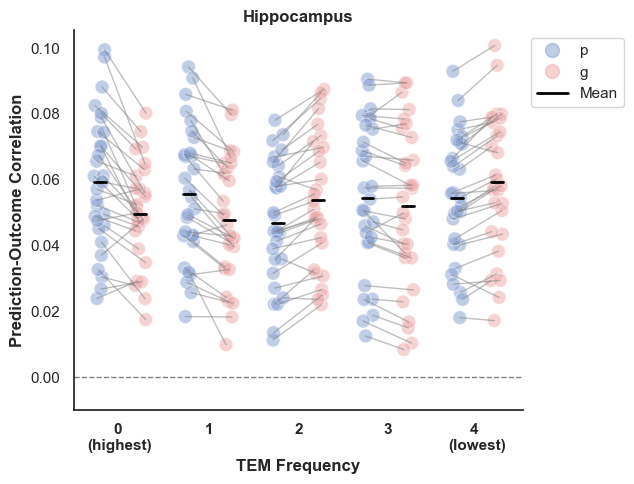

In [66]:
for region in [['Hippocampus']]:
    performance_all_averaged_hcecvmpfcTopg_region = performance_all_averaged_hcecvmpfcTopg[performance_all_averaged_hcecvmpfcTopg['brain_region'].isin(region)]
    #get the mean of the zvalues and Value of each TEM_component within each brain region and fmri_subject
    performance_all_averaged_hcecvmpfcTopg_mean = performance_all_averaged_hcecvmpfcTopg_region.groupby(['fmri_subject', 'TEM_component', 'cell_freq'], as_index=False).agg({'Value': 'mean', 'zvalue': 'mean'})
    plot_subjectConnected_performance_scatter(performance_all_averaged_hcecvmpfcTopg_mean,
                                                title=region[0], legend_title='',
                                                outer_x_order=['freq0', 'freq1','freq2','freq3','freq4'], outer_x_labels= ['0 \n(highest)', '1','2','3','4 \n(lowest)'], outer_x_column_name='cell_freq',
                                                inner_x_order=['p', 'g'], inner_x_labels=['p', 'g'], inner_x_column_name='TEM_component',
                                                y_column_name='Value',
                                                inner_x_colors=['#839DD1','#ECA8A9'],#['#70c17f','#7ca9cc'],#['#F49600','#9d84bf'], 
                                                subject_column_name='fmri_subject',
                                                outer_shift=1.5, inner_shift=0.9, jitter=0.2, figsize=(6.5, 5),
                                                legend_loc='upper left', legend_bbox_to_anchor=(1, 1), xlabel='TEM Frequency',
                                                dashed_zero_line=True)
                                                #save=f'./outputs/performance_TEM_hc_it32000.jpeg')

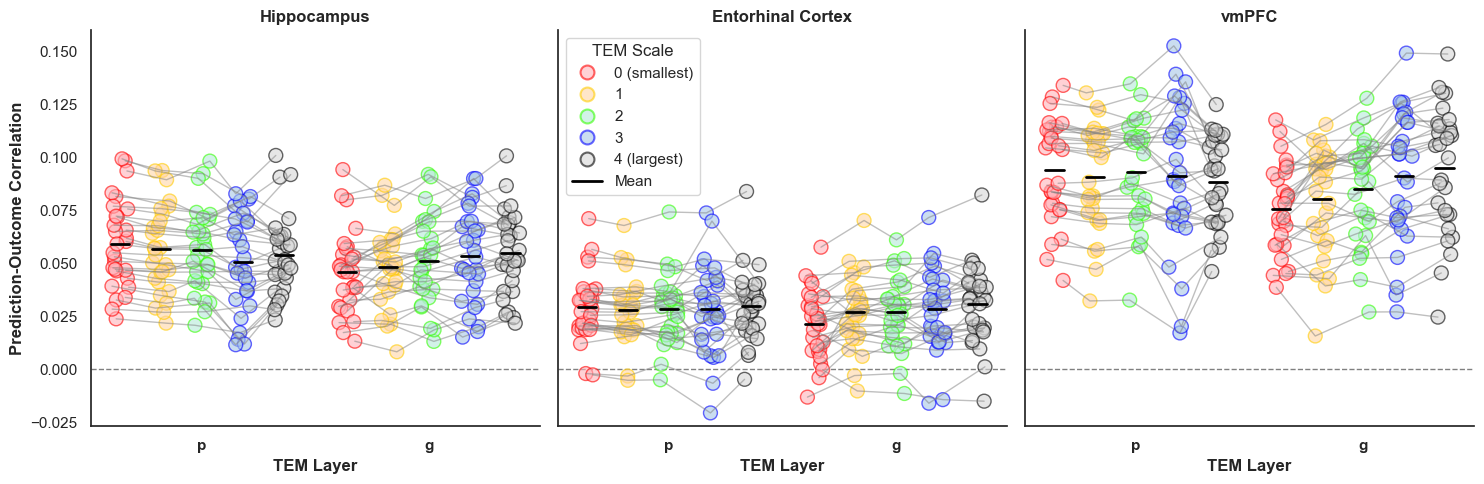

In [167]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
axes = axes.flatten()
regions = [['Hippocampus'], ['EntorhinalCortex'], ['vmPFC']]
region_names = ['Hippocampus', 'Entorhinal Cortex', 'vmPFC']
for idx, region in enumerate(regions):
    performance_all_averaged_hcecvmpfcTopg_region = performance_all_averaged_hcecvmpfcTopg[performance_all_averaged_hcecvmpfcTopg['brain_region'].isin(region)]
    #get the mean of the zvalues and Value of each TEM_component within each brain region and fmri_subject
    performance_all_averaged_hcecvmpfcTopg_mean = performance_all_averaged_hcecvmpfcTopg_region.groupby(['fmri_subject', 'TEM_component', 'cell_freq'], as_index=False).agg({'Value': 'mean', 'zvalue': 'mean'})
    plot_subjectConnected_performance_scatter(performance_all_averaged_hcecvmpfcTopg_mean,
                                                title=region_names[idx], legend_title='TEM Scale',
                                                outer_x_order=['p', 'g'], outer_x_labels= ['p', 'g'], outer_x_column_name='TEM_component',
                                                inner_x_order=['freq0', 'freq1','freq2','freq3','freq4'], inner_x_labels=['0 (smallest)', '1','2','3','4 (largest)'], inner_x_column_name='cell_freq',
                                                y_column_name='Value',
                                                inner_x_colors=['#FF0000','#FFCC00','#33FF00','#0000FF','#000000'], subject_column_name='fmri_subject',
                                                outer_shift=1.5, inner_shift=0.9, jitter=0.3, figsize=(6.5, 5),
                                                legend_loc='upper left', legend_bbox_to_anchor=None, yrange=(-0.027, 0.16),xlabel='TEM Layer',
                                                ax=axes[idx],  # Pass the subplot axis
                                                inner_x_filling_colors=['#FFB3BA', '#FFD6A5', '#B5EAD7', '#A7C7E7', '#D6D6D6'],
                                                dashed_zero_line='True')#'#FF9999', '#FFE08A', '#A8E6A3', '#91C8F6', '#B0B0B0'])

    if idx != 1:
        axes[idx].get_legend().remove()
plt.tight_layout()
plt.savefig('./outputs/performance_TEMfreqslope_hcecvmpfc_it50000.jpeg', dpi=600)
plt.show()

In [160]:
performance_all_averaged_hcecvmpfcTopg_mean = performance_all_averaged_hcecvmpfcTopg.groupby(['brain_region','fmri_subject', 'TEM_component', 'cell_freq'], as_index=False).agg({'Value': 'mean', 'zvalue': 'mean'})
freq_contrast_linear = {'freq0': -2,'freq1': -1,'freq2': 0,'freq3': 1,'freq4': 2}
freq_contrast_quadratic = {'freq0': 4,'freq1': 1,'freq2': 0,'freq3': 1,'freq4': 4}
freq_contrast_cubic = {'freq0': -8,'freq1': -1,'freq2': 0,'freq3': 1,'freq4': 8}
performance_all_averaged_hcecvmpfcTopg_mean['contrast_linear'] = performance_all_averaged_hcecvmpfcTopg_mean['cell_freq'].map(freq_contrast_linear)
performance_all_averaged_hcecvmpfcTopg_mean['contrast_quadratic'] = performance_all_averaged_hcecvmpfcTopg_mean['cell_freq'].map(freq_contrast_quadratic)
performance_all_averaged_hcecvmpfcTopg_mean['contrast_cubic'] = performance_all_averaged_hcecvmpfcTopg_mean['cell_freq'].map(freq_contrast_cubic)

# Function to calculate weighted sums
def calculate_weighted_sums(group):
    value_linear, zvalue_linear = (group['Value'] * group['contrast_linear']).sum(), (group['zvalue'] * group['contrast_linear']).sum()
    value_quadratic, zvalue_quadratic = (group['Value'] * group['contrast_quadratic']).sum(), (group['zvalue'] * group['contrast_quadratic']).sum()
    value_cubic, zvalue_cubic = (group['Value'] * group['contrast_cubic']).sum(), (group['zvalue'] * group['contrast_cubic']).sum()
    return pd.Series({'Value_freq_linear': value_linear, 'zvalue_freq_linear': zvalue_linear, 
                      'Value_freq_quadratic': value_quadratic, 'zvalue_freq_quadratic': zvalue_quadratic,
                      'Value_freq_cubic': value_cubic, 'zvalue_freq_cubic': zvalue_cubic})

performance_all_averaged_hcecvmpfcTopg_mean_freqcontrast = performance_all_averaged_hcecvmpfcTopg_mean.groupby(['brain_region', 'fmri_subject', 'TEM_component']).apply(calculate_weighted_sums).reset_index()
for contrast in ['zvalue_freq_linear', 'zvalue_freq_quadratic', 'zvalue_freq_cubic']:
    model = mixedlm(f"{contrast} ~ brain_region*TEM_component", 
                    performance_all_averaged_hcecvmpfcTopg_mean_freqcontrast, 
                    groups=performance_all_averaged_hcecvmpfcTopg_mean_freqcontrast["fmri_subject"])  #, re_formula="~cell_freq")
    result = model.fit()
    #print(result.summary())
    print(contrast)
    print('LL', result.llf)
    #calculate aic and bic
    k = len(result.fe_params) + len(result.random_effects)
    n = result.nobs
    aic = 2*k - 2*result.llf
    bic = np.log(n)*k - 2*result.llf
    print('AIC', aic)
    print('BIC', bic)
#print linear
print(mixedlm("zvalue_freq_linear ~ brain_region*TEM_component", performance_all_averaged_hcecvmpfcTopg_mean_freqcontrast, groups=performance_all_averaged_hcecvmpfcTopg_mean_freqcontrast["fmri_subject"]).fit().summary())

zvalue_freq_linear
LL 341.729642591451
AIC -613.459285182902
BIC -502.8923497103935
zvalue_freq_quadratic
LL 45.62084146486541
AIC -21.241682929730814
BIC 89.32525254277772
zvalue_freq_cubic
LL 142.930235316167
AIC -215.860470632334
BIC -105.29353515982547
                            Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           zvalue_freq_linear
No. Observations:           174               Method:                       REML              
No. Groups:                 29                Scale:                        0.0007            
Min. group size:            6                 Log-Likelihood:               341.7296          
Max. group size:            6                 Converged:                    Yes               
Mean group size:            6.0                                                               
----------------------------------------------------------------------------------------------
            

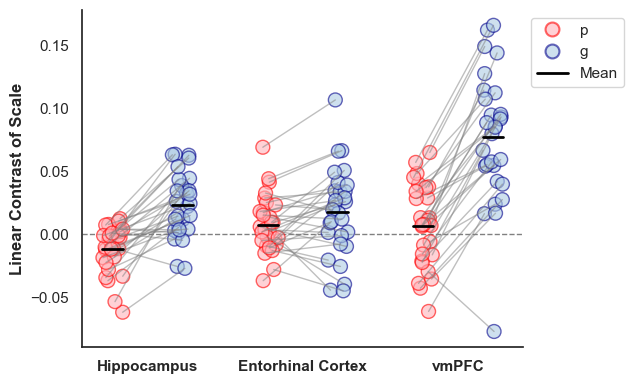

In [161]:
plot_subjectConnected_performance_scatter(performance_all_averaged_hcecvmpfcTopg_mean_freqcontrast,
                                                title='', legend_title='',
                                                outer_x_order=['Hippocampus', 'EntorhinalCortex', 'vmPFC'], outer_x_labels=['Hippocampus', 'Entorhinal Cortex', 'vmPFC'], outer_x_column_name='brain_region',
                                                inner_x_order=['p', 'g'], inner_x_labels=['p', 'g'], inner_x_column_name='TEM_component',
                                                y_column_name='Value_freq_linear',
                                                inner_x_colors=['#FF0000','#00008B'],
                                                inner_x_filling_colors=['#FFB3BA','#AECCE4'],
                                                subject_column_name='fmri_subject',
                                                outer_shift=1.5, inner_shift=0.9, jitter=0.2, figsize=(6.5, 4),
                                                legend_loc='upper left', legend_bbox_to_anchor=(1, 1), yaxis_label='Linear Contrast of Scale',
                                                dashed_zero_line=True,
                                                save='./outputs/performance_TEM_hcercvmpfc_linearcontrast_it32000.jpeg')


In [46]:
print(multiple_t_tests(performance_all_averaged_hcecvmpfcTopg, ['brain_region', 'TEM_component']))

          brain_region TEM_component    t_value        p_value  \
0     EntorhinalCortex             g  16.433173   9.453566e-49   
120   EntorhinalCortex             p  30.888460  5.479381e-165   
2080       Hippocampus             g  30.860800  3.054429e-116   
2200       Hippocampus             p  49.975450   0.000000e+00   

      p_value_corrected  
0          9.453566e-49  
120       1.095876e-164  
2080      4.072572e-116  
2200       0.000000e+00  


### TEM learning and loss curve

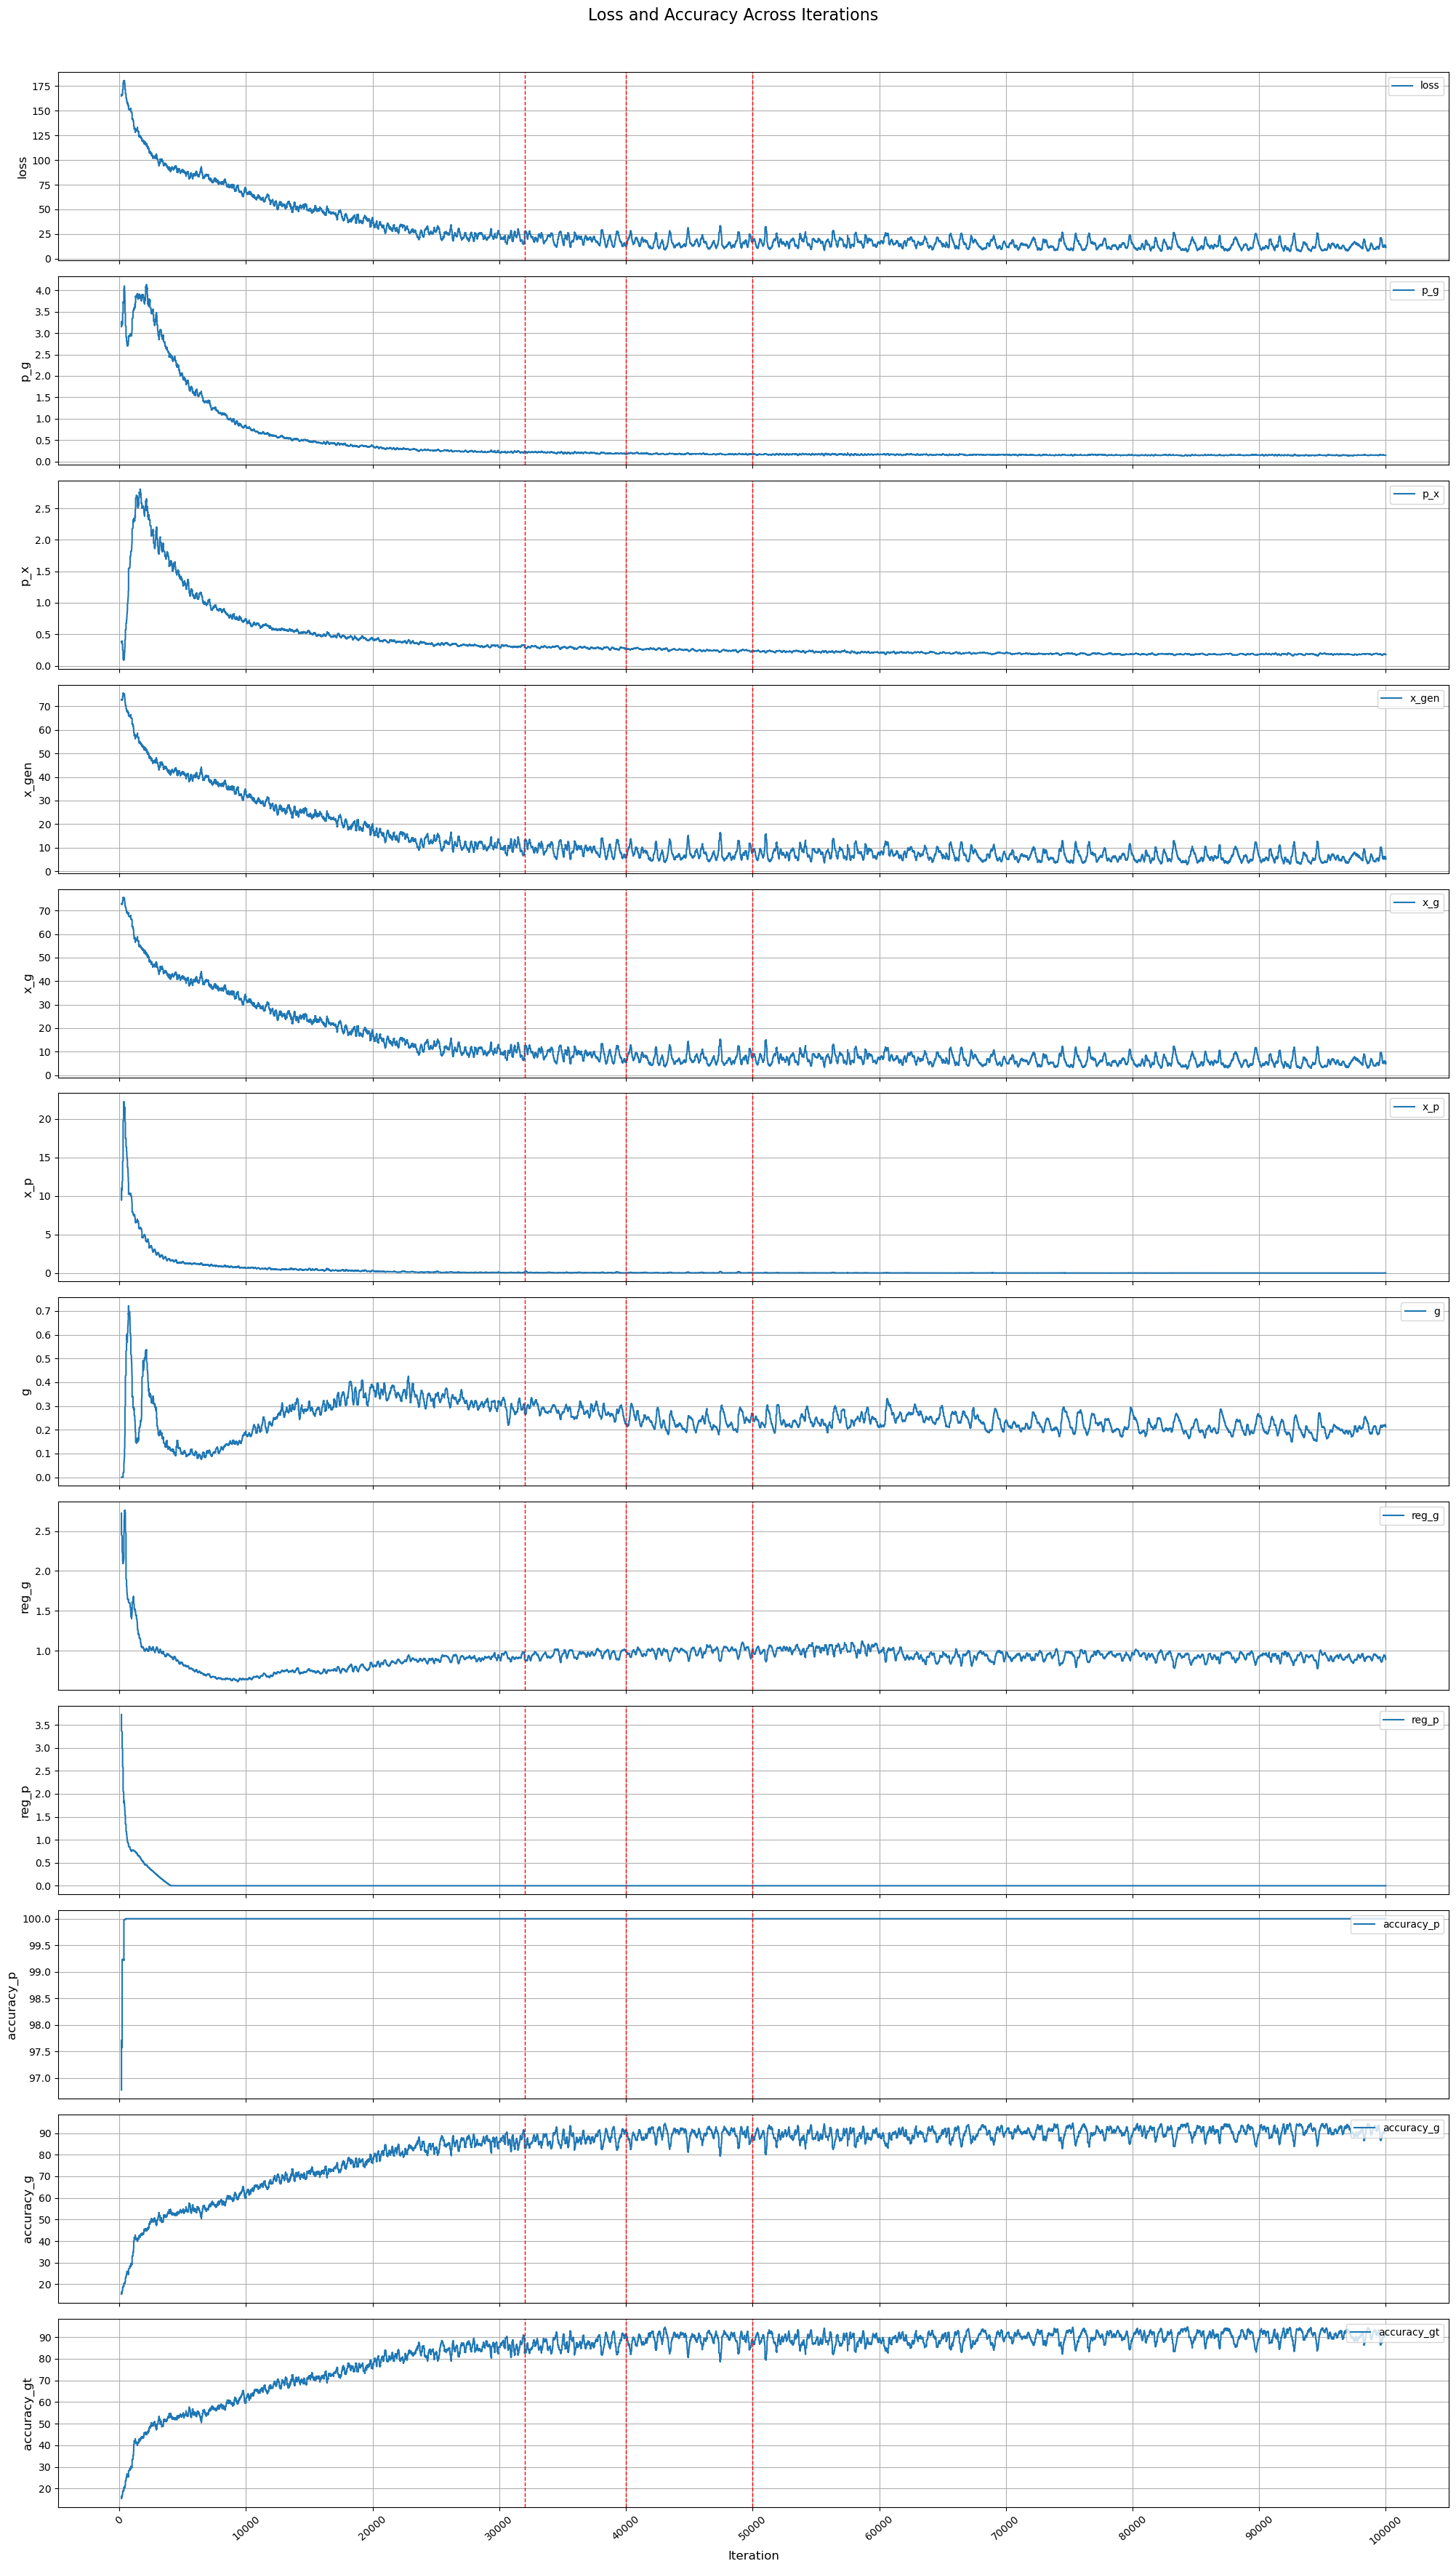

In [3]:
# Parse the log file by chunks
def parse_log_file_by_chunks(log_file_path):
    loss_acc = {
        "iteration": [],
        "loss": [],
        "p_g": [],
        "p_x": [],
        "x_gen": [],
        "x_g": [],
        "x_p": [],
        "g": [],
        "reg_g": [],
        "reg_p": [],
        "accuracy_p": [],
        "accuracy_g": [],
        "accuracy_gt": []
    }
    
    with open(log_file_path, 'r') as file:
        chunk = []
        for line in file:
            if line.strip():  # Non-blank line
                chunk.append(line.strip())
            else:  # Blank line indicates end of a chunk
                if chunk:
                    process_chunk(chunk, loss_acc)
                chunk = []
        # Process the last chunk if the file doesn't end with a blank line
        if chunk:
            process_chunk(chunk, loss_acc)
    
    return pd.DataFrame(loss_acc)

# function to process a single chunk
def process_chunk(chunk, loss_acc):
    latest_iteration = None
    for line in chunk:
        
        # Extract the latest iteration number
        iter_match = re.search(r'Iteration (\d+):', line)
        if iter_match:
            latest_iteration = int(iter_match.group(1))
    

        # Extract loss and accuracy values
        loss_pattern = r"Loss:\s*([\d.]+)\s*<p_g>\s*([\d.]+)\s*<p_x>\s*([\d.]+)\s*<x_gen>\s*([\d.]+)\s*<x_g>\s*([\d.]+)\s*<x_p>\s*([\d.]+)\s*<g>\s*([\d.]+)\s*<reg_g>\s*([\d.]+)\s*<reg_p>\s*([\d.]+)"
        accuracy_pattern = r"Accuracy:\s*<p>\s*([\d.]+)%\s*<g>\s*([\d.]+)%\s*<gt>\s*([\d.]+)%"

        loss_match = re.search(loss_pattern, line)
        accuracy_match = re.search(accuracy_pattern, line)


        if loss_match is not None:
            loss = float(loss_match.group(1).strip('.')) 
            p_g = float(loss_match.group(2))
            p_x = float(loss_match.group(3))
            x_gen = float(loss_match.group(4))
            x_g = float(loss_match.group(5))
            x_p = float(loss_match.group(6))
            g = float(loss_match.group(7))
            reg_g = float(loss_match.group(8))
            reg_p = float(loss_match.group(9))
        
        if accuracy_match is not None:
            accuracy_p = float(accuracy_match.group(1))
            accuracy_g = float(accuracy_match.group(2))
            accuracy_gt = float(accuracy_match.group(3))

        
        if latest_iteration is not None:
            loss_acc["iteration"].append(latest_iteration)
            loss_acc["loss"].append(loss)
            loss_acc["p_g"].append(p_g)
            loss_acc["p_x"].append(p_x)
            loss_acc["x_gen"].append(x_gen)
            loss_acc["x_g"].append(x_g)
            loss_acc["x_p"].append(x_p)
            loss_acc["g"].append(g)
            loss_acc["reg_g"].append(reg_g)
            loss_acc["reg_p"].append(reg_p)
            loss_acc["accuracy_p"].append(accuracy_p)
            loss_acc["accuracy_g"].append(accuracy_g)
            loss_acc["accuracy_gt"].append(accuracy_gt)


def plot_loss_acc_in_subplots(df, xtick_interval=10000, vertical_lines=[50000, 32000]):
    loss_acc_components = ["loss", "p_g", "p_x", "x_gen", "x_g", "x_p", "g", "reg_g", "reg_p", "accuracy_p", "accuracy_g", "accuracy_gt"]
    num_components = len(loss_acc_components)
    
    fig, axes = plt.subplots(nrows=num_components, ncols=1, figsize=(20, 3 * num_components), sharex=True)
    fig.suptitle("Loss and Accuracy Across Iterations", fontsize=16)
    
    xticks = range(0, int(df["iteration"].max()) + xtick_interval, xtick_interval)
    
    for i, component in enumerate(loss_acc_components):
        axes[i].plot(df["iteration"], df[component], label=component, color="tab:blue")
        axes[i].set_ylabel(component, fontsize=12)
        axes[i].grid(True)
        axes[i].legend(loc="upper right")
        axes[i].set_xticks(xticks)  
        axes[i].set_xticklabels(rotation=40, labels=xticks) 
        
        for vline in vertical_lines:
            axes[i].axvline(x=vline, color="red", linestyle="--", linewidth=1, label=f"x={vline}")
    
    axes[-1].set_xlabel("Iteration", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the title
    plt.show()

def plot_loss_acc_in_subplots_filtered(df, max_iteration = 'max', xtick_interval=10000, vertical_lines=[50000, 32000], smoothing_window=None):
    loss_acc_components = ["loss", "p_g", "p_x", "x_gen", "x_g", "x_p", "g", "reg_g", "reg_p", "accuracy_p", "accuracy_g", "accuracy_gt"]
    num_components = len(loss_acc_components)
    
    fig, axes = plt.subplots(nrows=num_components, ncols=1, figsize=(20, 3 * num_components), sharex=True)
    fig.suptitle("Loss and Accuracy Across Iterations", fontsize=16)
    if max_iteration == 'max':  
        xticks = range(0, int(df["iteration"].max()) + xtick_interval, xtick_interval)
    else:
        xticks = range(0, max_iteration + xtick_interval, xtick_interval)
    
    
    for i, component in enumerate(loss_acc_components):
        if smoothing_window is not None:
            df[component] = df[component].rolling(window=smoothing_window).mean()
        axes[i].plot(df[df['iteration'] <= max_iteration]["iteration"], df[df['iteration'] <= max_iteration][component], label=component, color="tab:blue")
        axes[i].set_ylabel(component, fontsize=12)
        axes[i].grid(True)
        axes[i].legend(loc="upper right")
        axes[i].set_xticks(xticks)  
        axes[i].set_xticklabels(rotation=40, labels=xticks) 
        
        for vline in vertical_lines:
            axes[i].axvline(x=vline, color="red", linestyle="--", linewidth=1, label=f"x={vline}")
    
    axes[-1].set_xlabel("Iteration", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the title
    plt.show()


log_file_path = '/home/yma/EmoTEM/scripts/perceptual/Summaries/2024-10-22/run0/report.log'
df_loss_acc = parse_log_file_by_chunks(log_file_path)
plot_loss_acc_in_subplots_filtered(df_loss_acc, max_iteration=100000, xtick_interval=10000, vertical_lines=[40000, 50000, 32000], smoothing_window=100)


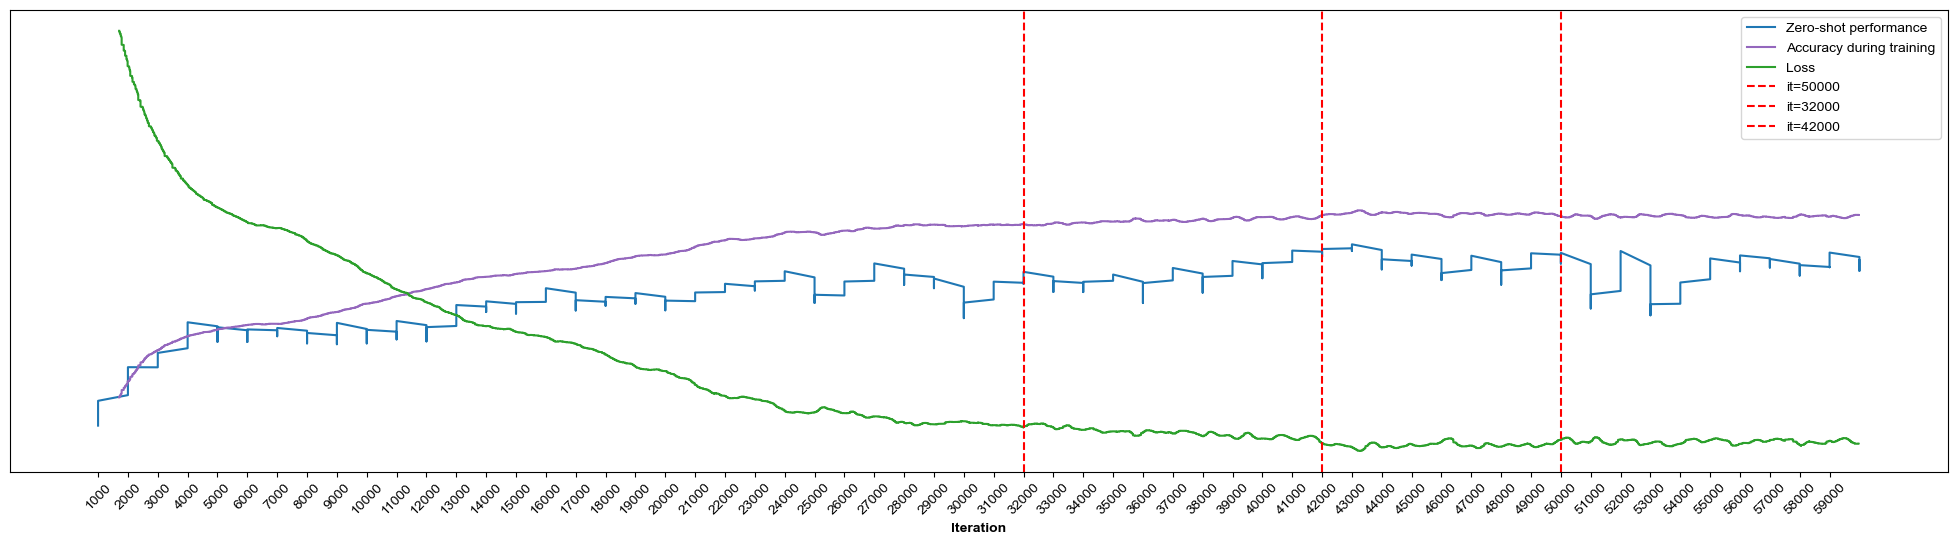

In [11]:
zeroshot_df = pd.read_csv('./outputs/TEM_performace/across_movies/MDSseed121/walkRandomSeed42/zero_shot_performance_14brainmovies_envMDSseed121.csv')
zeroshot_df = zeroshot_df[zeroshot_df['iteration'] <= 60000]
zeroshot_df = zeroshot_df.groupby(['iteration', 'zero_shot']).mean().reset_index()
#zeroshot_df = zeroshot_df[zeroshot_df['TEMwalker'] == 1]
#smooth the zero-shot performance
zeroshot_df['zero_shot'] = zeroshot_df['zero_shot'].rolling(window=5).mean()
#font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.figure(figsize=(25, 6))
#sns.set_style('whitegrid')
plt.plot(zeroshot_df['iteration'], zeroshot_df['zero_shot'], label='Zero-shot performance', color='tab:blue')
df_loss_acc_filtered = df_loss_acc[df_loss_acc['iteration'] <= 60000]
#df_loss_acc_filtered['accuracy_gt'] = df_loss_acc_filtered['accuracy_gt'].rolling(window=1000).mean()
df_loss_acc_filtered['accuracy_g'] = df_loss_acc_filtered['accuracy_g'].rolling(window=1000).mean()
df_loss_acc_filtered['loss'] = df_loss_acc_filtered['loss'].rolling(window=1000).mean()
#plt.plot(df_loss_acc_filtered['iteration'], df_loss_acc_filtered['accuracy_gt'], label='Accuracy gt', color='tab:orange')
plt.plot(df_loss_acc_filtered['iteration'], df_loss_acc_filtered['accuracy_g'], label='Accuracy during training', color='tab:purple')
plt.plot(df_loss_acc_filtered['iteration'], df_loss_acc_filtered['loss'], label='Loss', color='tab:green')

plt.axvline(x=50000, color='red', linestyle='--', label='it=50000')
plt.axvline(x=32000, color='red', linestyle='--', label='it=32000')
plt.axvline(x=42000, color='red', linestyle='--', label='it=42000')
#xticks = range(0, int(zeroshot_df["iteration"].max()) + 1000, 1000)
xticks = range(1000, 60000, 1000)
plt.xticks(xticks, rotation=45)
plt.xlabel('Iteration', weight='bold')
#plt.ylabel('Zero-shot performance', weight='bold')
plt.yticks([])
plt.legend(loc='upper right')
plt.savefig('./outputs/TEM_performance.jpeg', dpi=600)
plt.show()

### Differentiability 

In [ ]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import scipy.cluster.hierarchy as hierarchy
from scipy.spatial.distance import pdist

%matplotlib inline

# Base directory
base_path = './outputs/rep3/ratings_prediction_yhat/brain/category'
out_path = './outputs/rep3/ratings_prediction_yhat/brain/category/correlation_matrices'
os.makedirs(out_path, exist_ok=True)

# get yhat files
yhat_files = sorted(glob(os.path.join(base_path, 'yhat_sub-*_Hippocampus.csv')))
emotion_categories = ['Anger', 'Anxiety', 'Fear', 'Surprise', 'Guilt', 'Disgust', 'Sad', 'Regard',
                      'Satisfaction', 'WarmHeartedness', 'Happiness', 'Pride', 'Love']

n_subjects = len(yhat_files)
ncols = 4
nrows = (n_subjects + ncols - 1) // ncols

# --- Correlation Matrices ---
fig_corr, axes_corr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes_corr = axes_corr.flatten()

# --- Dendrogram ---
fig_dendrogram, axes_dendrogram = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes_dendrogram = axes_dendrogram.flatten()

# --- Confusion Matrices ---
fig_conf, axes_conf = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes_conf = axes_conf.flatten()

for idx, yhat_file in enumerate(yhat_files):
    subject_id = os.path.basename(yhat_file).split('_')[1]
    y_file = os.path.join(base_path, f'y_{subject_id}_Hippocampus.csv')

    if not os.path.exists(y_file):
        print(f"Missing actual data for {subject_id}")
        continue

    yhat_df = pd.read_csv(yhat_file)
    y_df = pd.read_csv(y_file)

    
    corr = yhat_df[emotion_categories].corr()
    corr.to_csv(os.path.join(out_path, f'yhat_corr_Hippocampus_{subject_id}.csv'))
    


In [5]:
from collections import Counter
print(Counter(y_top1))
print(Counter(yhat_top1))

Counter({'Guilt': 2519, 'Regard': 1403, 'Satisfaction': 960, 'Happiness': 674, 'Love': 608, 'Pride': 342, 'Anxiety': 318, 'Sad': 317, 'Fear': 119, 'Disgust': 62, 'WarmHeartedness': 46, 'Anger': 14, 'Surprise': 10})
Counter({'Regard': 4532, 'Guilt': 2855, 'Satisfaction': 4, 'Pride': 1})


In [4]:
from audioop import avg
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import scipy.cluster.hierarchy as hierarchy
from sklearn.linear_model import LinearRegression
from scipy.stats import rankdata
from glob import glob
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import statsmodels.api as sm
#parital correlation package 
import pingouin as pg
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Emotion definitions
EMOTIONS = ['Anger','Anxiety','Fear','Surprise','Guilt','Disgust','Sad',
            'Regard','Satisfaction','WarmHeartedness','Happiness','Pride','Love']
POSITIVES = {'Regard','Satisfaction','WarmHeartedness','Happiness','Pride','Love'}
NEGATIVES= {'Anger','Anxiety','Fear','Surprise','Guilt','Disgust','Sad'}

# load matrices
def load_subject_matrices(data_dir):
    files = sorted(glob(os.path.join(data_dir, "yhat_corr_Hippocampus_sub-*.csv")))
    subj_ids = [os.path.basename(f).split("sub-")[1].split(".csv")[0] for f in files]
    matrices = [pd.read_csv(f, index_col=0).loc[EMOTIONS, EMOTIONS].values for f in files]
    return subj_ids, matrices

#plot the correlation matrix from all subjects in one figure's subplots and add subject id as title
def plot_correlation_matrices(subject_ids, matrices, save_path=None):
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['font.sans-serif'] = ['Arial']
    n_subjects = len(matrices)
    ncols = 5
    nrows = (n_subjects + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()
    for i, mat in enumerate(matrices):
        ax = axes[i]
        sns.heatmap(mat, ax=ax, cmap="coolwarm", vmin=-1, vmax=1,
                    xticklabels=EMOTIONS, yticklabels=EMOTIONS,
                    cbar=False,
                    #annot=True, 
                    fmt=".2f", annot_kws={"size": 5},
                    square=True)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)
        ax.set_title(subject_ids[i], fontsize=15)
    #remove axes that are not used
    for ax in axes[n_subjects:]:
        ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.show()
    

def plot_group_average_correlation_matrix(matrices, mask=None, save_path=None, add_values=True,colorbar=False):
    plt.close('all')  # Ensure no interference from previous figures
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial"]

    group_avg_corr = np.mean(matrices, axis=0)
    fig, ax = plt.subplots(figsize=(12, 12))  # Increase size if labels are long

    sns.heatmap(group_avg_corr, mask=mask,
                cmap="coolwarm", vmin=-1, vmax=1,
                xticklabels=EMOTIONS, yticklabels=EMOTIONS,
                cbar=False, annot=add_values, fmt=".2f", annot_kws={"size": 20}, ax=ax,
                square=True)
    
    # Move x-axis labels to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    # Move y-axis labels to the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    
    ax.tick_params(labelsize=25)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if colorbar:        
        # Manually create colorbar on the left
        cbar_ax = fig.add_axes([0.08, 0.3, 0.015, 0.4])  # x, y, width, height
        norm = plt.Normalize(vmin=-1, vmax=1)
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')

    fig.tight_layout()

    if save_path:
        fig.canvas.draw() 
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()

def plot_empirical_model_correlation_matrix(subject_ids, matrices, test_subject_id, save_path=None,add_values=True):
    #calculate the group average correlation matrix from all subjects except the test subject
    #get matrices from all subjects except the test subject
    matrices = [m for i, m in enumerate(matrices) if subject_ids[i] != test_subject_id]
    mask = np.tril(np.ones_like(matrices[0], dtype=bool))
    plot_group_average_correlation_matrix(matrices, mask,save_path,add_values)



#plot the dendrograms from all subjects in one figure's subplots and add subject id as title and the label should be emotion categories
def plot_dendrograms(subject_ids, matrices, save_path=None):
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['font.sans-serif'] = ['Arial']
    n_subjects = len(matrices)
    ncols = 5
    nrows = (n_subjects + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()
    for i, mat in enumerate(matrices):
        ax = axes[i]
        dist_matrix = 1 - mat
        linkage = hierarchy.linkage(squareform(dist_matrix, checks=False), method='average')
        hierarchy.dendrogram(linkage, ax=ax, labels=EMOTIONS, orientation='left', leaf_font_size=15,
                             color_threshold=0, above_threshold_color='black')
        ax.set_title(subject_ids[i], fontsize=15)
    #remove axes that are not used
    for ax in axes[n_subjects:]:
        ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
    plt.show()
    

def plot_group_average_dendrogram(matrices, save_path=None):
    # Compute average correlation and distance matrix
    group_avg_corr = np.mean(matrices, axis=0)
    dist_matrix = 1 - group_avg_corr

    linkage = hierarchy.linkage(squareform(dist_matrix, checks=False), method='average')

    plt.close('all') 
    fig, ax = plt.subplots(figsize=(8, 10))  
    #use black color for the dendro
    hierarchy.dendrogram(linkage, labels=EMOTIONS, orientation='left',
                         leaf_font_size=20, ax=ax, color_threshold=0, above_threshold_color='black')
    #make the distance labels at the bottom of the dendrogram larger
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.3) 

    if save_path:
        fig.canvas.draw()  
        fig.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()
    

# vectorize by extracting upper triangle excluding diagonal
def vectorize_matrix(mat):
    triu_idx = np.triu_indices_from(mat, k=1)
    return mat[triu_idx]

# get index mapping for (i, j) pairs in upper triangle (excluding diagonal)
def get_upper_triangle_index_map():
    triu_idx = np.triu_indices(len(EMOTIONS), k=1)
    return {(i, j): k for k, (i, j) in enumerate(zip(*triu_idx))}

# valence model 1: single value for positive-positive and negative-negative; zero for pos-neg
def valence_model_1(train_vectors, return_matrix=False):
    idx_map = get_upper_triangle_index_map()
    pp_indices, nn_indices = [], []

    for (i, j), k in idx_map.items():
        emo1, emo2 = EMOTIONS[i], EMOTIONS[j]
        if emo1 in POSITIVES and emo2 in POSITIVES:
            pp_indices.append(k)
        elif emo1 in NEGATIVES and emo2 in NEGATIVES:
            nn_indices.append(k)

    train_stack = np.stack(train_vectors)
    avg_pp = train_stack[:, pp_indices].mean()
    avg_nn = train_stack[:, nn_indices].mean() 
    avg_pp_nn = np.mean([avg_pp, avg_nn])

    model = np.zeros((len(EMOTIONS), len(EMOTIONS)))
    for (i, j), k in idx_map.items():
        emo1, emo2 = EMOTIONS[i], EMOTIONS[j]
        if k in pp_indices or k in nn_indices:
            model[i, j] = avg_pp_nn
        # else (positive-negative): leave as 0

    return vectorize_matrix(model) if not return_matrix else model

# valence model 2: 3 separate values: pos-pos, neg-neg, pos-neg
def valence_model_2(train_vectors, return_matrix=False):
    idx_map = get_upper_triangle_index_map()
    pp_indices, nn_indices, pn_indices = [], [], []

    for (i, j), k in idx_map.items():
        emo1, emo2 = EMOTIONS[i], EMOTIONS[j]
        if emo1 in POSITIVES and emo2 in POSITIVES:
            pp_indices.append(k)
        elif emo1 in NEGATIVES and emo2 in NEGATIVES:
            nn_indices.append(k)
        elif (emo1 in POSITIVES and emo2 in NEGATIVES) or (emo1 in NEGATIVES and emo2 in POSITIVES):
            pn_indices.append(k)

    train_stack = np.stack(train_vectors)
    avg_pp = train_stack[:, pp_indices].mean()
    avg_nn = train_stack[:, nn_indices].mean()
    avg_pn = train_stack[:, pn_indices].mean()

    model = np.zeros((len(EMOTIONS), len(EMOTIONS)))
    for (i, j), k in idx_map.items():
        if k in pp_indices:
            model[i, j] = avg_pp
        elif k in nn_indices:
            model[i, j] = avg_nn
        elif k in pn_indices:
            model[i, j] = avg_pn

    return vectorize_matrix(model) if not return_matrix else model

def plot_valence_model_matrix(subject_ids, matrices, model_func,test_subject_id, save_path=None,add_values=True):
    plt.close('all')
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(12, 12))  
    # Exclude test subject and get training vectors
    train_vectors = [vectorize_matrix(m) for i, m in enumerate(matrices) if subject_ids[i] != test_subject_id]
    
    # Get the full (non-vectorized) model matrix
    model = model_func(train_vectors, return_matrix=True)

    # Create a mask for the lower triangle and diagonal
    mask = np.tril(np.ones_like(model, dtype=bool))
    
    plot_group_average_correlation_matrix([model], mask, save_path,add_values)

# run cross-validation across subjects
def run_cross_validation(data_dir):
    subj_ids, matrices = load_subject_matrices(data_dir)
    vectors = [vectorize_matrix(m) for m in matrices]

    results = []

    for i in range(len(subj_ids)):
        test_id = subj_ids[i]
        test_vec = vectors[i]
        train_vecs = vectors[:i] + vectors[i+1:]

        # model 1: Group average
        group_avg_vec = np.mean(train_vecs, axis=0)

        # model 2: valence model 1
        val1_vec = valence_model_1(train_vecs)

        # model 3: valence model 2
        val2_vec = valence_model_2(train_vecs)

        df = pd.DataFrame({
            'test_vec': test_vec,
            'group_avg_vec': group_avg_vec,
            'val1_vec': val1_vec,
            'val2_vec': val2_vec
        })
        def residualize(y, X):
            """ Regress y on X and return the residuals. """
            reshaped_X = X.reshape(-1, 1)
            model = LinearRegression().fit(reshaped_X, y)
            residuals = y - model.predict(reshaped_X)
            return residuals

        def spearman_partial_corr_resid(x, y, z, regress_both_xy=False):
            # Rank transform inputs for Spearman correlation
            x_rank = rankdata(x)
            y_rank = rankdata(y)
            z_rank = rankdata(z)
            
            # Residualize x and y with respect to z
            resid_x = residualize(x_rank, z_rank)
            resid_y = residualize(y_rank, z_rank)
            
            # Correlate the residuals
            return spearmanr(resid_x, y_rank)[0] if not regress_both_xy else spearmanr(resid_x, resid_y)[0]

        results.append({
            "subject": test_id,
            'group_avg_vec': group_avg_vec,
            'val1_vec': val1_vec,
            'val2_vec': val2_vec,
            'test_vec': test_vec,
            "r_group_avg": spearmanr(group_avg_vec, test_vec)[0],
            "r_valence1": spearmanr(val1_vec, test_vec)[0],
            "r_valence2": spearmanr(val2_vec, test_vec)[0],
            'r_full_valence1': spearmanr(group_avg_vec, val1_vec)[0],
            'r_full_valence2': spearmanr(group_avg_vec, val2_vec)[0],
            #partial correlation (test_vec, group_avg_vec, accounted for val1_vec)
            'r_group_avg_accounted_for_valence1': spearman_partial_corr_resid(test_vec, group_avg_vec, val1_vec),
            'r_group_avg_accounted_for_valence2': spearman_partial_corr_resid(test_vec, group_avg_vec, val2_vec)
            #'r_group_avg_accounted_for_valence1': pg.partial_corr(
            #    data=df, x='group_avg_vec', y='test_vec', covar='val1_vec', method='spearman')['r'].values[0], 
            #partial correlation (test_vec, group_avg_vec, accounted for val2_vec)
            #'r_group_avg_accounted_for_valence2': pg.partial_corr(
            #    data=df, x='group_avg_vec', y='test_vec', covar='val2_vec', method='spearman')['r'].values[0], 
        })

    return pd.DataFrame(results)


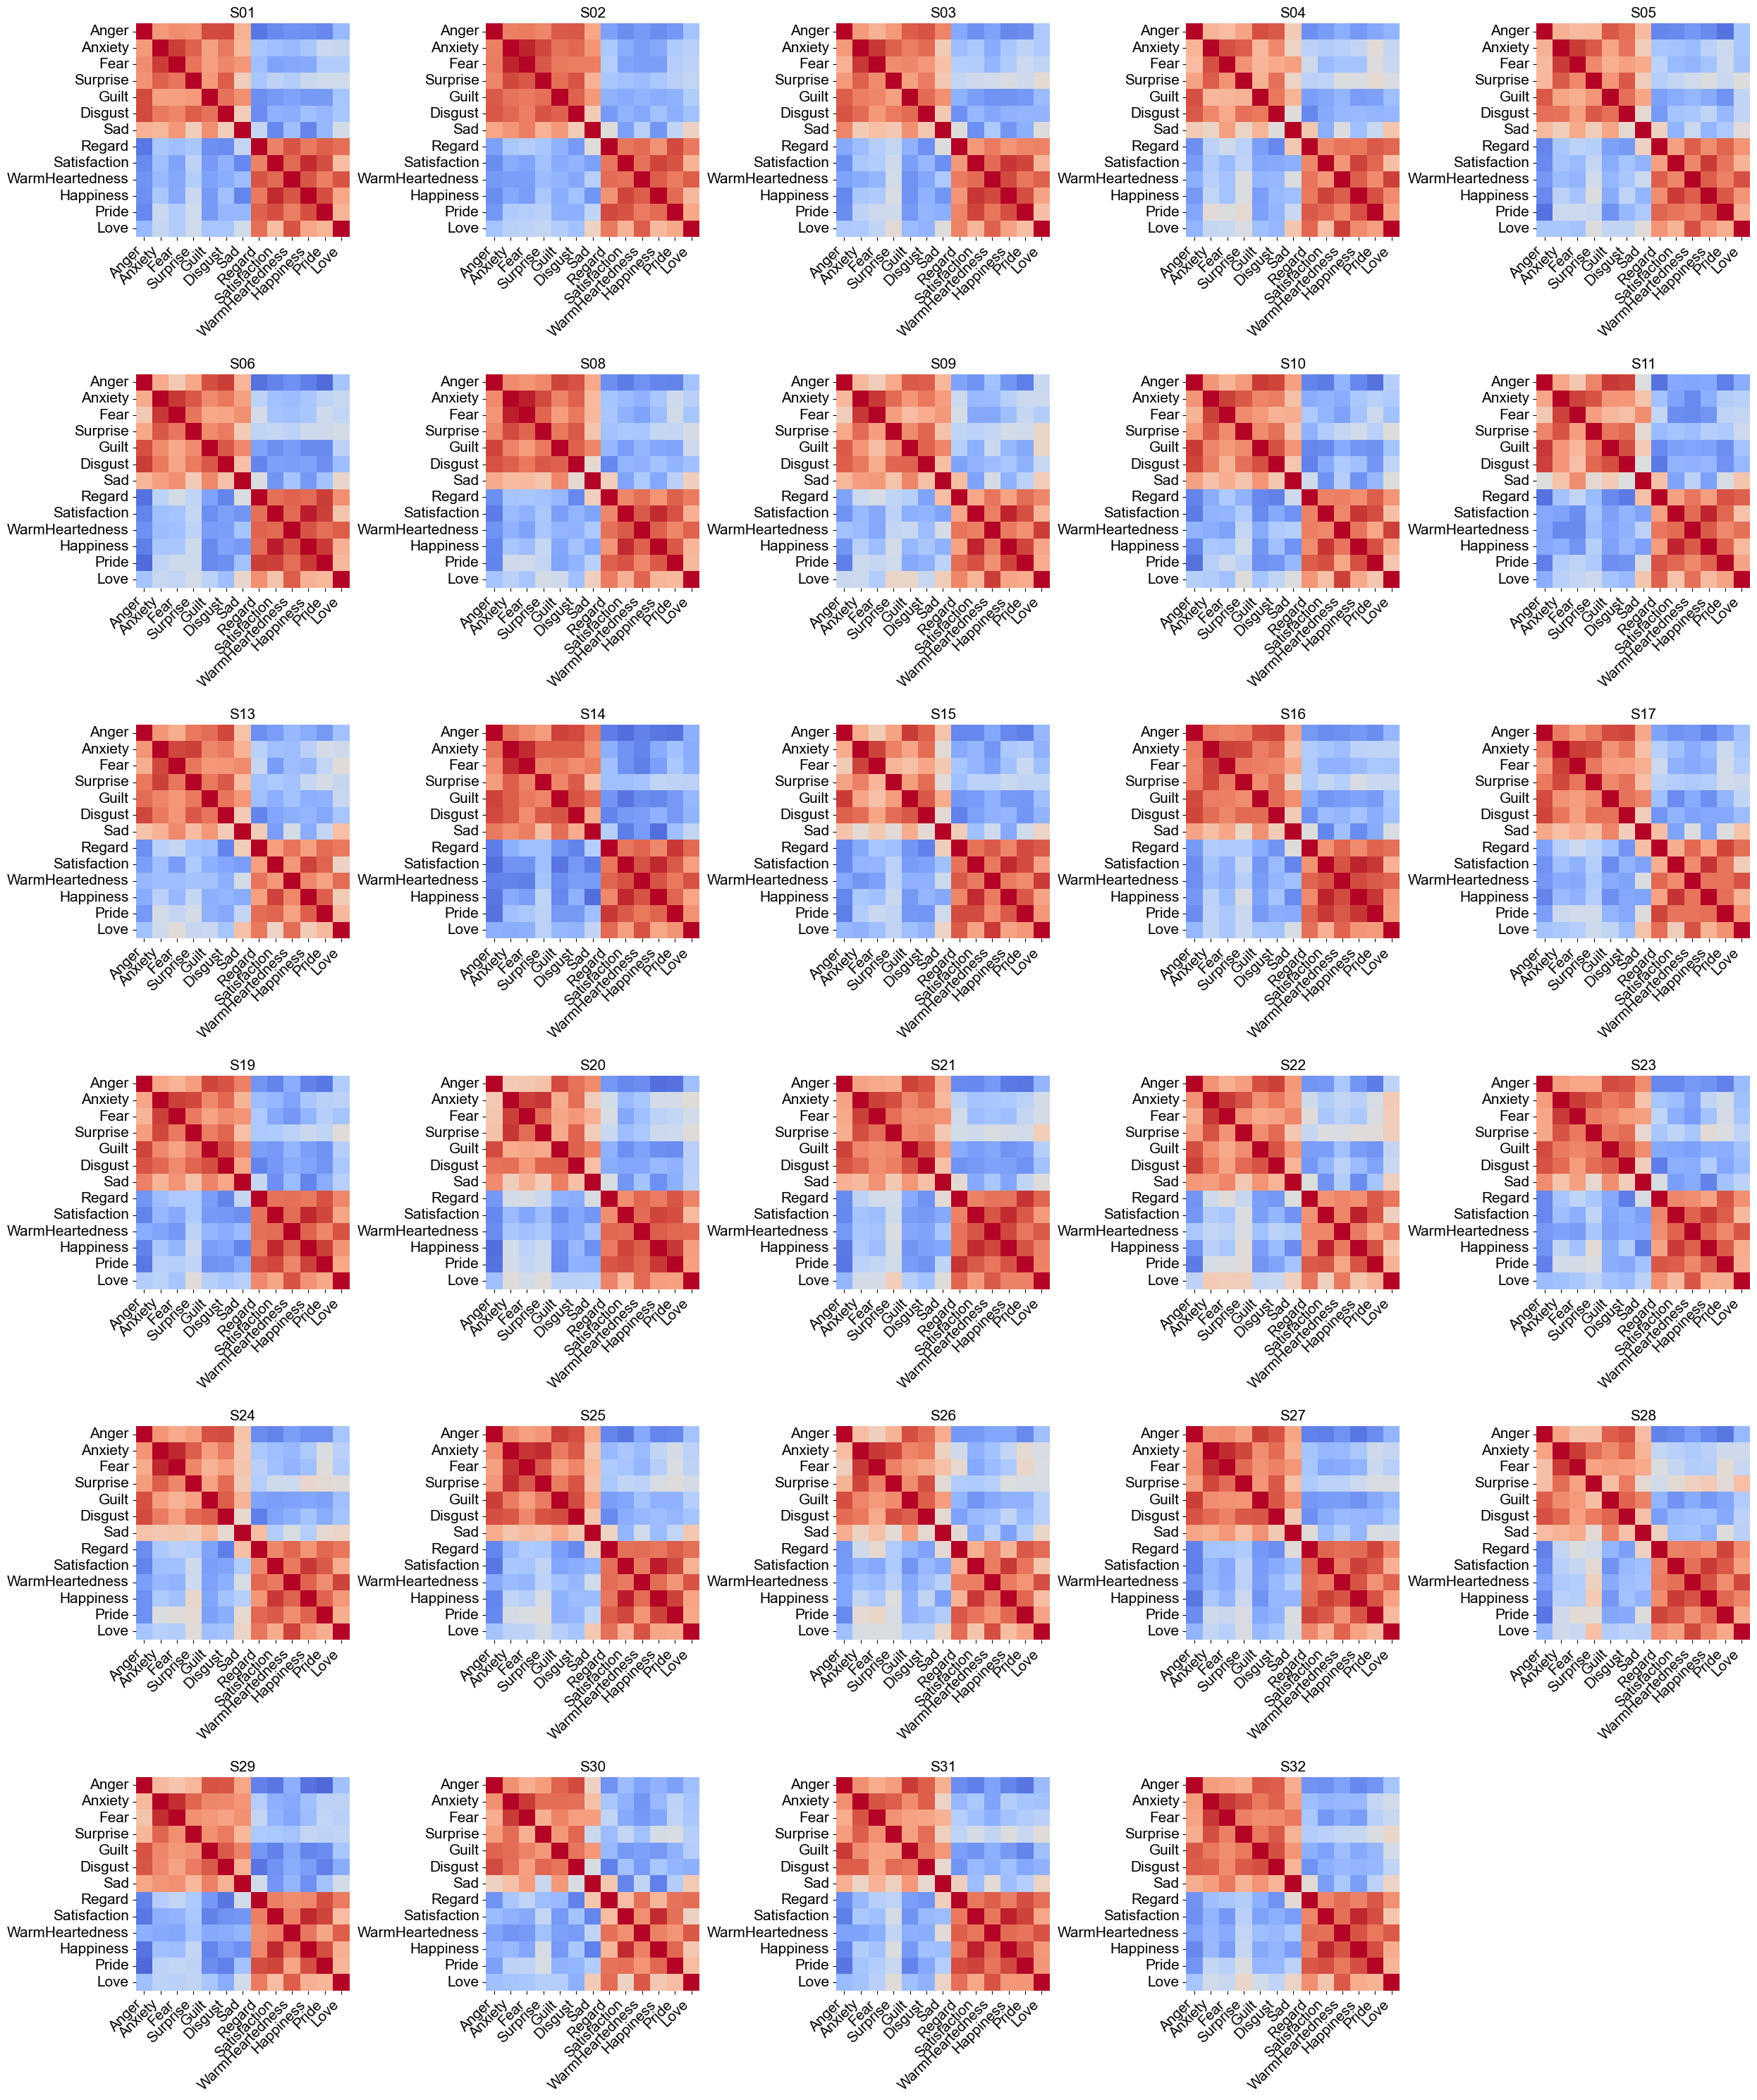

In [5]:
data_path = "./outputs/rep3/ratings_prediction_yhat/brain/category/correlation_matrices"
subj_ids, matrices = load_subject_matrices(data_path)
plot_correlation_matrices(subj_ids, matrices, "./outputs/predictedRatings_correlationMatrices_Hippocampus_allsubjects.jpeg")
#plot_group_average_correlation_matrix(matrices, save_path="./outputs/predictedRatings_correlationMatrix_Hippocampus_groupaverage.jpeg")
#plot_dendrograms(subj_ids, matrices, "./outputs/predictedRatings_dendrogram_Hippocampus_allsubjects.jpeg")
#plot_group_average_dendrogram(matrices, "./outputs/predictedRatings_groupAverageDendrogram_Hippocampus_groupaverage.jpeg")

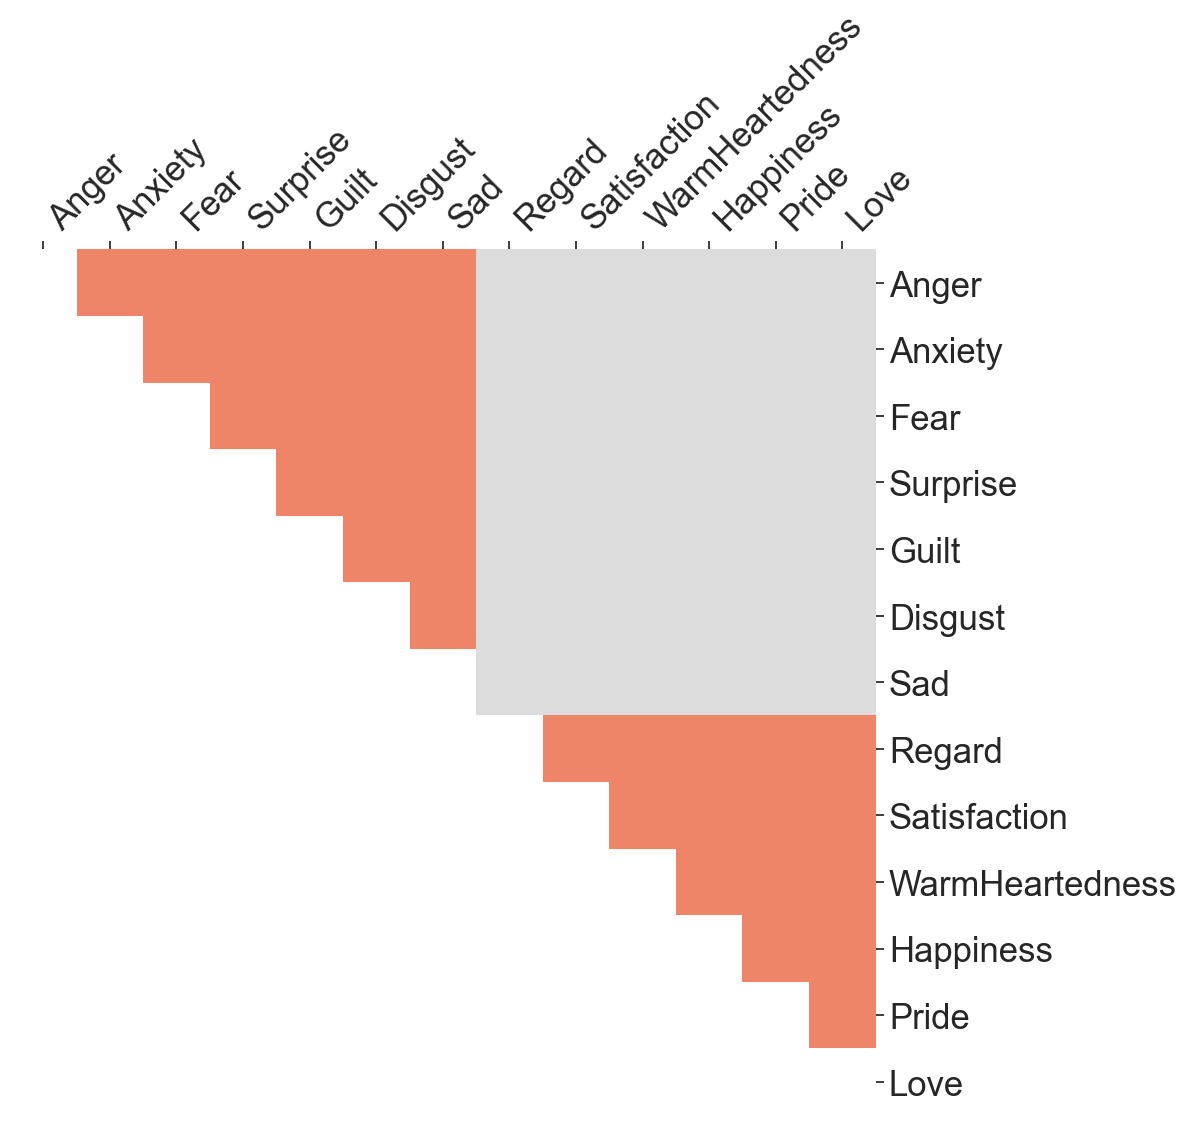

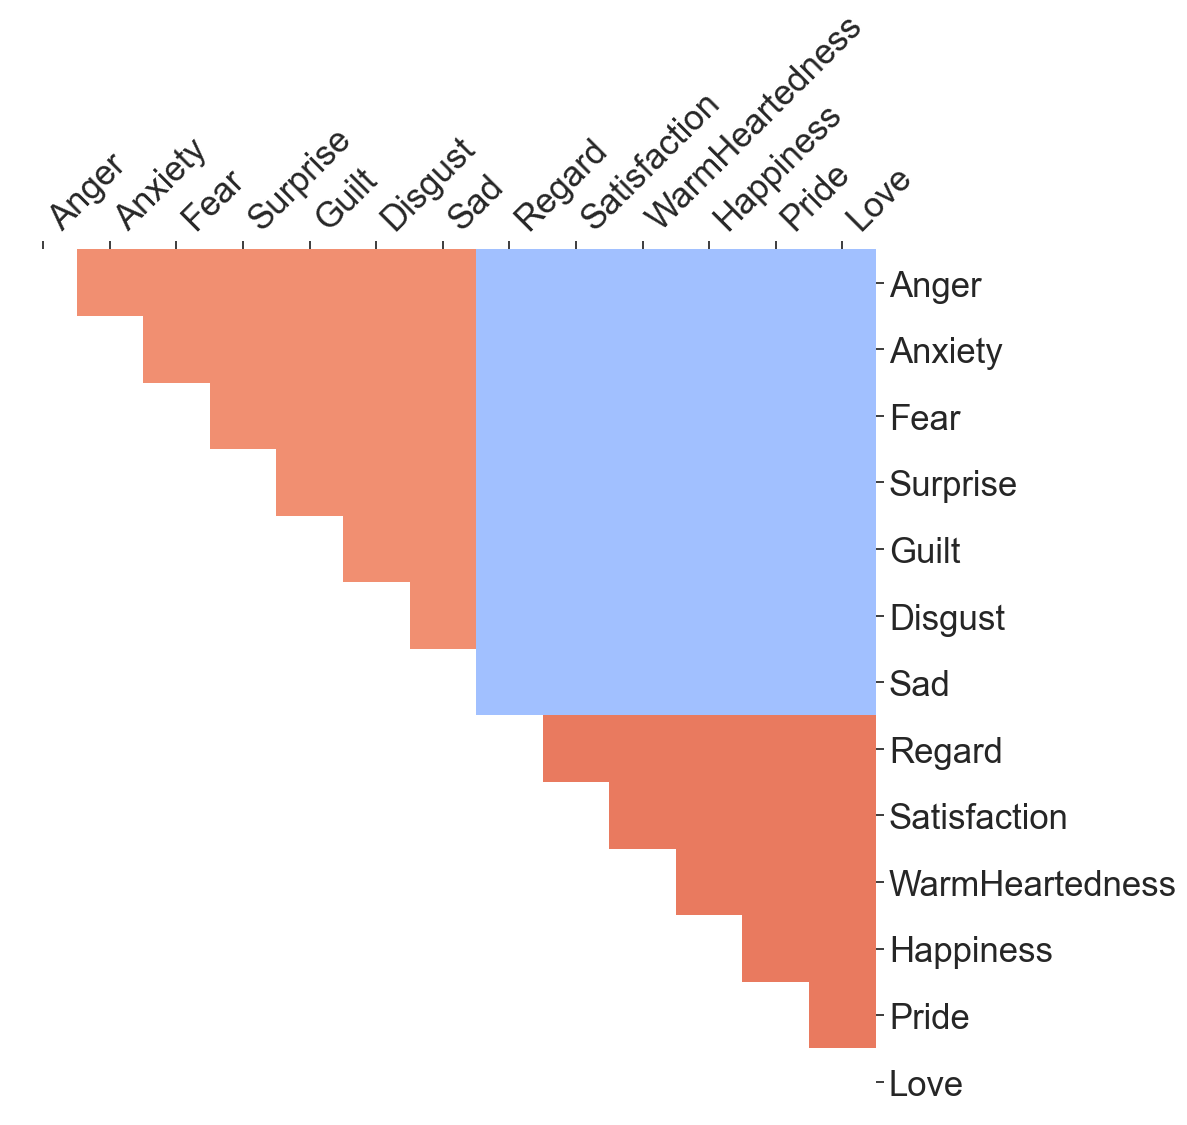

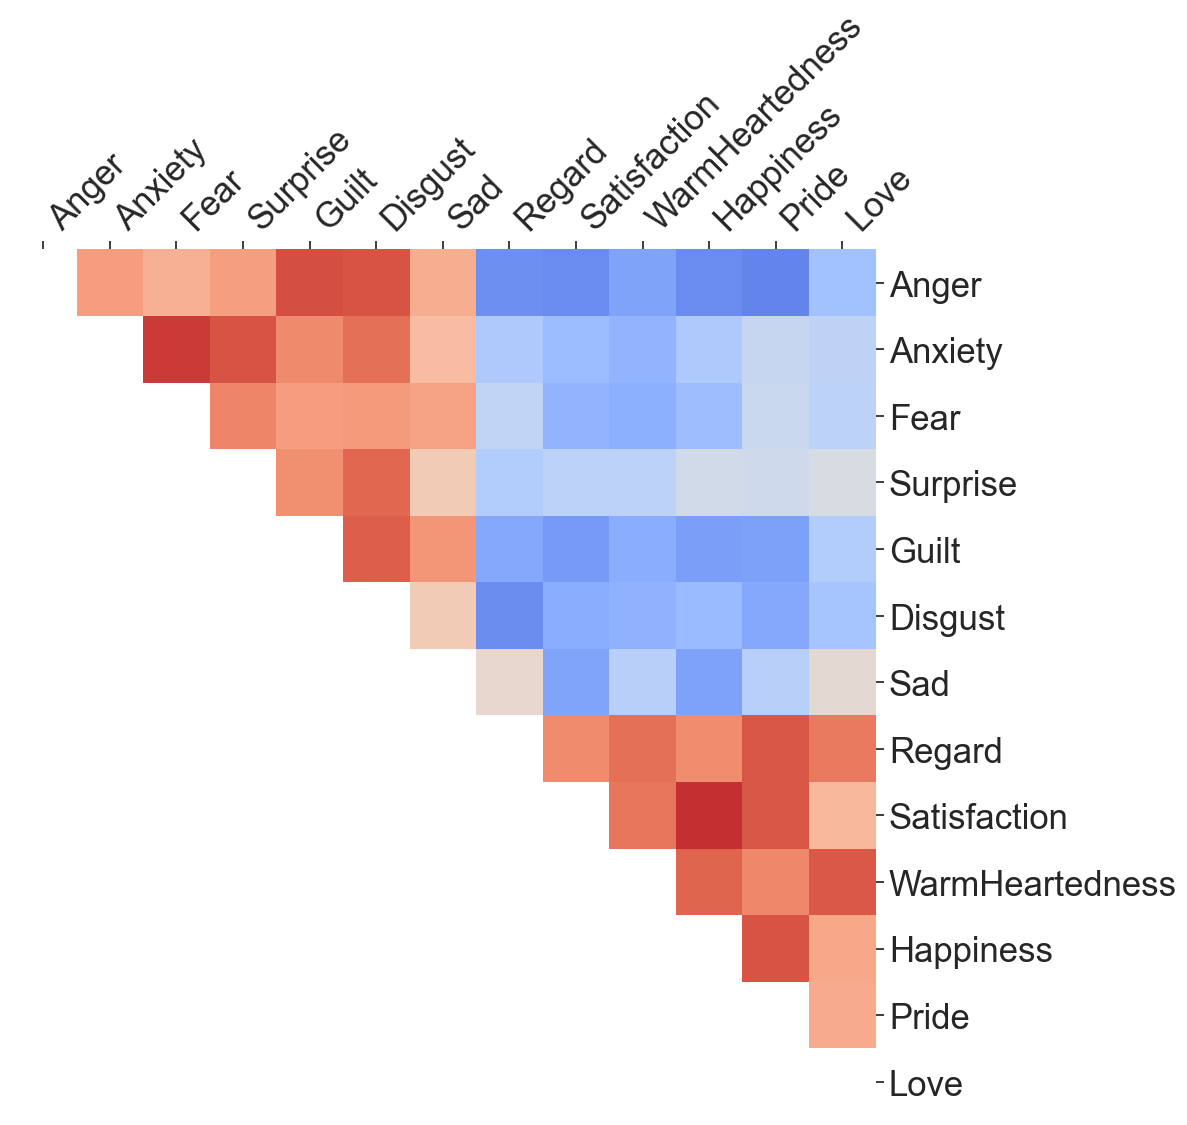

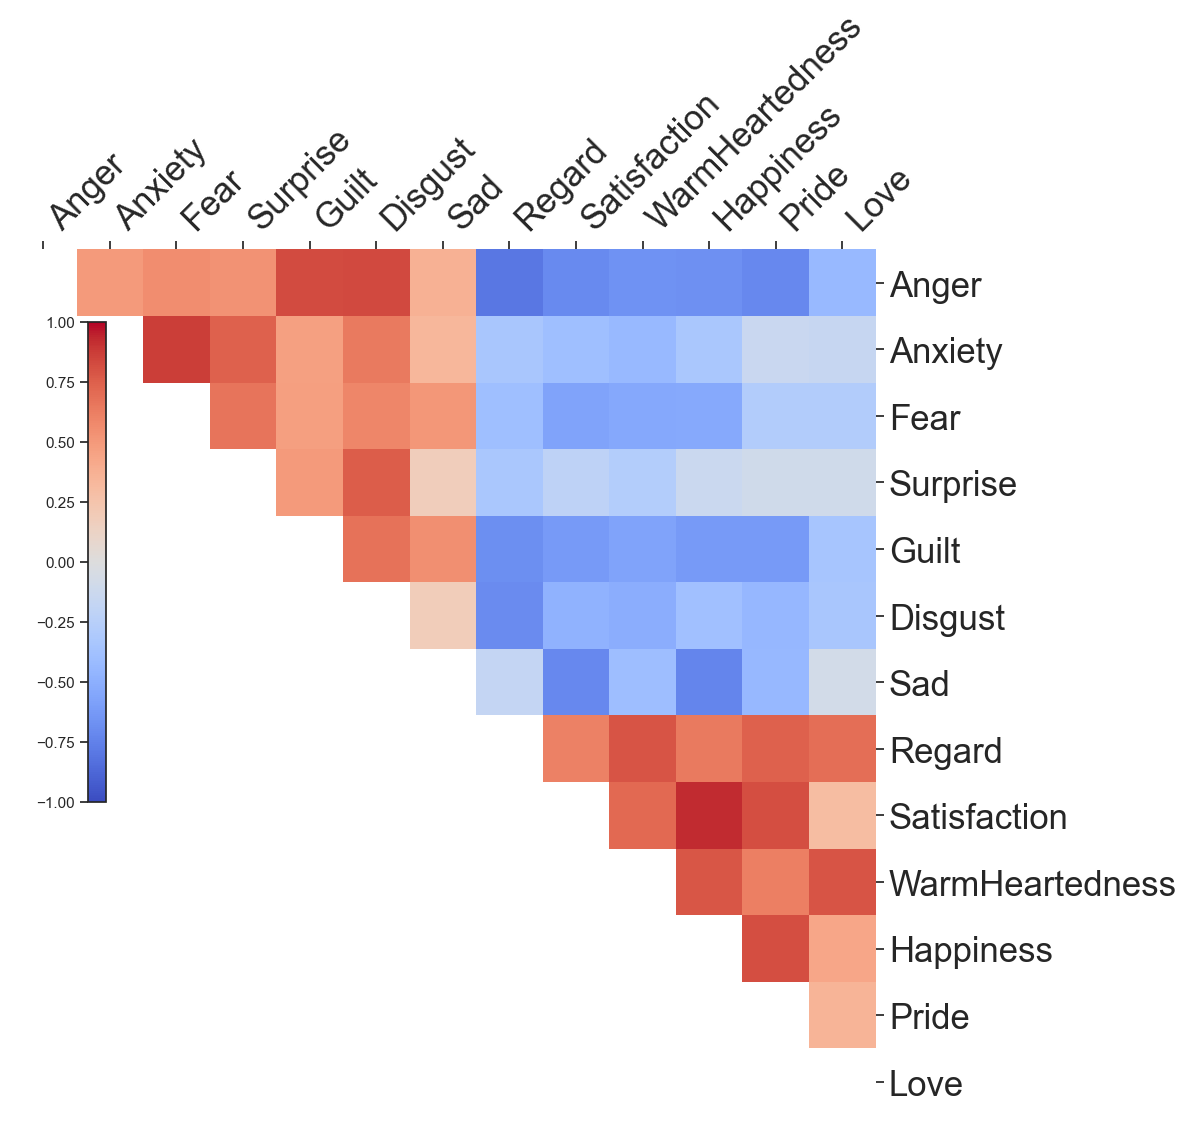

In [66]:
data_path = "./outputs/rep3/ratings_prediction_yhat/brain/category/correlation_matrices"
subj_ids, matrices = load_subject_matrices(data_path)
test_subject_id = subj_ids[0]
plot_valence_model_matrix(subj_ids, matrices, model_func=valence_model_1, test_subject_id=test_subject_id, save_path=f"./outputs/predictedRatings_valenceModel1_Hippocampus_test{test_subject_id}_noValues.jpeg", add_values=False)
plot_valence_model_matrix(subj_ids, matrices, model_func=valence_model_2, test_subject_id=test_subject_id, save_path=f"./outputs/predictedRatings_valenceModel2_Hippocampus_test{test_subject_id}_noValues.jpeg", add_values=False)
plot_empirical_model_correlation_matrix(subj_ids, matrices, test_subject_id, save_path=f"./outputs/predictedRatings_empiricalModel_Hippocampus_test{test_subject_id}_noValues.jpeg", add_values=False)
plot_group_average_correlation_matrix([matrices[0]], mask=np.tril(np.ones_like(matrices[0], dtype=bool)), save_path=f"./outputs/predictedRatings_Hippocampus_test{test_subject_id}_noValues.jpeg", add_values=False, colorbar=True)

   subject                                      group_avg_vec  \
0      S01  [0.4799172121110608, 0.3806021144013501, 0.469...   
1      S02  [0.4754959959472965, 0.37776549233667245, 0.46...   
2      S03  [0.47991239125630514, 0.38738689714312197, 0.4...   
3      S04  [0.4848838872106727, 0.38960781241149806, 0.47...   
4      S05  [0.48419033606537504, 0.38935967763319296, 0.4...   
5      S06  [0.48294683548596057, 0.3929763518773899, 0.47...   
6      S08  [0.47714982131069633, 0.38173723222424255, 0.4...   
7      S09  [0.4859133705063279, 0.3944078309470928, 0.473...   
8      S10  [0.4792297325940265, 0.3876290276131572, 0.470...   
9      S11  [0.48230710092826906, 0.3927229410053642, 0.46...   
10     S13  [0.4791957359117372, 0.38640145912551654, 0.46...   
11     S14  [0.47354037684290595, 0.37997856974897876, 0.4...   
12     S15  [0.48333148263304543, 0.3934351195809796, 0.47...   
13     S16  [0.47487404640445463, 0.37890192890720115, 0.4...   
14     S17  [0.4750276814

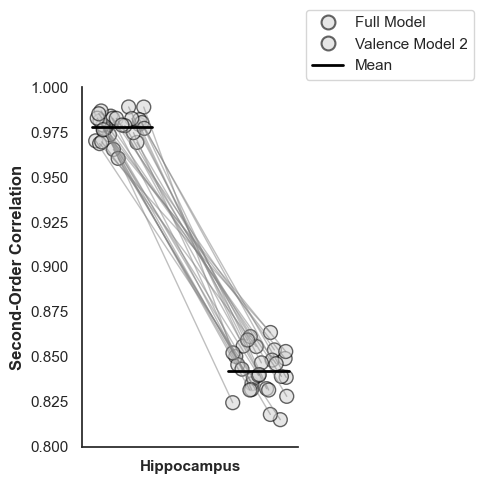

In [27]:
data_path = "./outputs/rep3/ratings_prediction_yhat/brain/category/correlation_matrices"
df_results = run_cross_validation(data_path)
print(df_results)
print("\nMean correlations:")
print(df_results.mean(numeric_only=True))
#print sd
print("\nStandard deviations:")
print(df_results.std(numeric_only=True))
#do t-test  against 0 for each model
for model in ['r_group_avg', 'r_valence2','r_group_avg_accounted_for_valence2']:
    t_test = ttest_1samp(fisher_z(df_results[model]), 0)
    print(f"{model}: t-statistic = {t_test.statistic}, p-value = {t_test.pvalue}")
df_results = df_results.melt(id_vars=['subject'], var_name='model', value_name='correlation')
df_results['region'] = 'Hippocampus'
#subset the df_results to only include the models that are in the inner_x_order
df_results = df_results[df_results['model'].isin(['r_group_avg', 'r_valence2'])]
df_results['model'] = pd.Categorical(df_results['model'], categories=['r_group_avg', 'r_valence2','r_group_avg_accounted_for_valence2'], ordered=True)

plot_subjectConnected_performance_scatter(df_results,
                                        title='', legend_title='',
                                        outer_x_order=['Hippocampus'], outer_x_labels= ['Hippocampus'], outer_x_column_name='region',
                                        inner_x_order=['r_group_avg', 'r_valence2'], inner_x_labels=['Full Model', 'Valence Model 2'], inner_x_column_name='model',
                                        y_column_name='correlation',
                                        inner_x_colors=['#000000','#000000','#000000'], subject_column_name='subject',
                                        outer_shift=1.5, inner_shift=0.9, jitter=0.3, figsize=(5, 5),
                                        legend_loc='lower left', legend_bbox_to_anchor=(1, 1), yrange=(0.8,1),xlabel='',
                                        yaxis_label='Second-Order Correlation',
                                        inner_x_filling_colors=['#D6D6D6', '#D6D6D6', '#D6D6D6'], 
                                        save=f"./outputs/predictedRatings_Hippocampus_acrossSubjects_secondaryCorrelation.jpeg")